In [1]:
#Run this cell to set up imports

from IPython.display import display, Math
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from statsmodels.tsa.seasonal import seasonal_decompose
import cvxpy as cp

# STAT 153: Time Series Homework Three
## Due Date: Tuesday, March 11th, 11:59 P.M.

# Scoring Breakdown (Undergraduate)
|Question|Points|
|---|---|
|1a|4|
|1b|4|
|1c|2|
|2a|4|
|2b|4|
|2c|2|
|3a|3|
|3b|5|
|4a|6|
|4bi|4|
|4bii|4|
|4biii|4|
|5a|6|
|5bi|4|
|5bii|4|
|5biii|4|
|6a|8|
|6bi|5|
|6bii|5|
|6biii|5|
|**Total**|87|

       Month  Search_Popularity  t
0 2004-01-01                  4  1
1 2004-02-01                  4  2
2 2004-03-01                  4  3
3 2004-04-01                  4  4
4 2004-05-01                  4  5


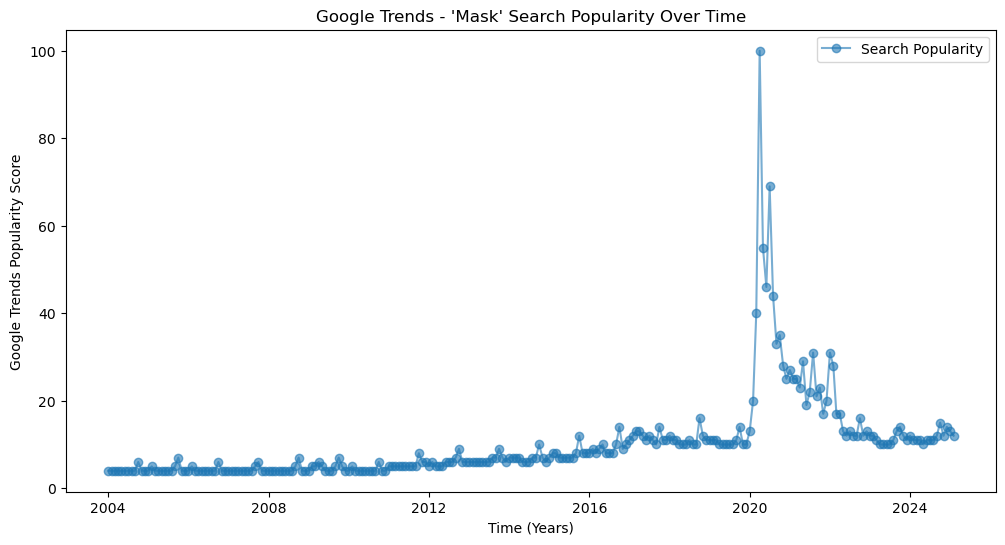

In [214]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import Ridge

# Load the Google Trends dataset
mask = pd.read_csv("mask_data.csv")

# Drop the first row (if it contains misplaced column headers)
mask = mask.iloc[1:].reset_index(drop=False)

# Rename columns for clarity
mask.columns = ["Month", "Search_Popularity"]

# Convert "Month" column to datetime format
mask["Month"] = pd.to_datetime(mask["Month"])
mask["Search_Popularity"] = pd.to_numeric(mask["Search_Popularity"])

# Add a time index (t = 1 for the first month, increasing sequentially)
mask["t"] = np.arange(1, len(mask) + 1)

# Check the data
print(mask.head())

# Plot the raw time series
plt.figure(figsize=(12,6))
plt.plot(mask["Month"], mask["Search_Popularity"], label="Search Popularity", linestyle="-", marker="o", alpha=0.6)
plt.xlabel("Time (Years)")
plt.ylabel("Google Trends Popularity Score")
plt.title("Google Trends - 'Mask' Search Popularity Over Time")
plt.legend()
plt.show()

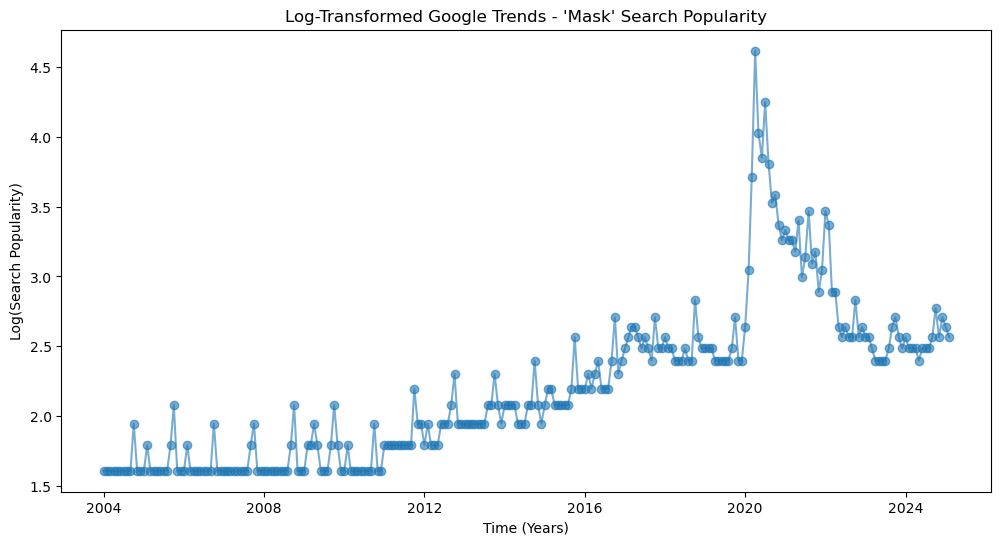

In [215]:
# Apply logarithm transformation (handling zero values)
mask["Log_Search_Popularity"] = np.log1p(mask["Search_Popularity"])  # log1p(x) = log(1 + x) to avoid log(0) issues

# Plot the log-transformed data
plt.figure(figsize=(12,6))
plt.plot(mask["Month"], mask["Log_Search_Popularity"], linestyle="-", marker="o", alpha=0.6)
plt.xlabel("Time (Years)")
plt.ylabel("Log(Search Popularity)")
plt.title("Log-Transformed Google Trends - 'Mask' Search Popularity")
plt.show()

In [216]:
# Define the number of observations
n = len(mask)

# Create the time index as the independent variable
x = np.arange(1, n + 1)

# Construct the full design matrix X_full
X_full = np.column_stack([np.ones(n), x - 1])

# Add truncated basis functions
for i in range(n - 2):
    c = i + 2  # Shifted time breakpoints
    xc = ((x > c).astype(float)) * (x - c)  # Only positive part
    X_full = np.column_stack([X_full, xc])

# Print a preview of the design matrix
print(X_full[:5])  # Show the first 5 rows

[[ 1.  0. -0. ... -0. -0. -0.]
 [ 1.  1.  0. ... -0. -0. -0.]
 [ 1.  2.  1. ... -0. -0. -0.]
 [ 1.  3.  2. ... -0. -0. -0.]
 [ 1.  4.  3. ... -0. -0. -0.]]


In [217]:
# Define response variable (log-transformed search popularity)
y = mask["Log_Search_Popularity"].values

# Fit the OLS model
mdfull = sm.OLS(y, X_full).fit()

# Display summary
print(mdfull.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 15 Mar 2025   Prob (F-statistic):                nan
Time:                        18:46:54   Log-Likelihood:                 6629.5
No. Observations:                 254   AIC:                        -1.275e+04
Df Residuals:                       0   BIC:                        -1.185e+04
Df Model:                         253                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6094        inf          0        n

/srv/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/srv/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/srv/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


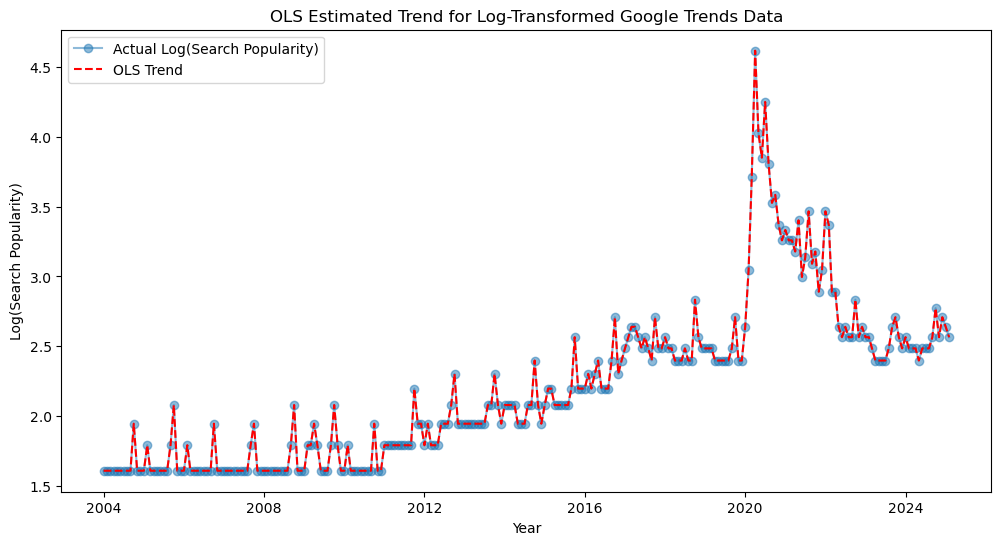

In [218]:
import matplotlib.pyplot as plt

# Generate predicted values from the OLS model
mask["OLS_Trend"] = mdfull.predict(X_full)

# Plot original data vs. OLS fitted trend
plt.figure(figsize=(12,6))

# Plot actual log-transformed search popularity
plt.plot(mask["Month"], mask["Log_Search_Popularity"], label="Actual Log(Search Popularity)", linestyle="-", marker="o", alpha=0.5)

# Plot the OLS fitted trend
plt.plot(mask["Month"], mask["OLS_Trend"], label="OLS Trend", linestyle="--", color="red")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Log(Search Popularity)")
plt.title("OLS Estimated Trend for Log-Transformed Google Trends Data")
plt.legend()

# Show plot
plt.show()


## 1a)

In [219]:
def solve_ridge(X, y, lambda_val, penalty_start=2):
    """
    Solves the Ridge regression problem using convex optimization.
    
    Arguments:
    X -- Design matrix
    y -- Response variable
    lambda_val -- Regularization strength
    penalty_start -- Index to start applying regularization (default is 2)
    
    Returns:
    Estimated coefficients (Ridge solution)
    """
    n, p = X.shape

    # Define variable for regression coefficients
    beta = cp.Variable(p)

    # Define Ridge regression objective: Squared Loss + L2 Regularization
    loss = cp.sum_squares(X @ beta - y)  # Residual sum of squares
    reg = lambda_val * cp.sum_squares(beta[penalty_start:])  # Regularization term
    objective = cp.Minimize(loss + reg)

    # Solve the optimization problem
    prob = cp.Problem(objective)
    prob.solve()

    return beta.value  # Return the estimated coefficients

In [220]:
# Define different regularization strengths
lambda_values = [1, 10, 100, 1000]

# Store results for each λ
ridge_estimates = {}

for lam in lambda_values:
    ridge_estimates[lam] = solve_ridge(X_full, y, lambda_val=lam)

# Print Ridge coefficients for λ=1000
print(ridge_estimates[1000])

[ 1.60808602e+00  5.01985108e-03  1.35189480e-06 -9.64166667e-07
 -1.19693874e-05 -3.66840062e-05 -8.01162924e-05 -1.47237832e-04
 -2.42940093e-04 -3.71967307e-04 -5.38820766e-04 -4.11157557e-04
 -3.29040419e-04 -2.95648699e-04 -3.13832700e-04 -2.03825524e-04
 -1.50189549e-04 -1.54961776e-04 -2.20029012e-04 -3.47123104e-04
 -5.37755870e-04 -7.93092005e-04 -9.31436891e-04 -6.64942303e-04
 -4.62514280e-04 -3.22390288e-04 -2.42345283e-04 -3.75102702e-05
  1.12582976e-04  2.10761748e-04  2.59740754e-04  2.62023943e-04
  2.19855522e-04  1.35217673e-04  9.87272419e-06  1.81920022e-04
  3.16504566e-04  4.15061675e-04  4.78710159e-04  5.08153771e-04
  5.03617551e-04  4.64818385e-04  3.90969544e-04  2.80819477e-04
  1.32725667e-04 -5.52352252e-05 -1.02797706e-04  1.42188076e-04
  3.41351853e-04  4.92653407e-04  5.93711166e-04  6.41650906e-04
  6.33004692e-04  5.63662938e-04  4.28883054e-04  2.23358784e-04
 -5.86450079e-05 -4.23086817e-04 -6.93544938e-04 -5.87814061e-04
 -5.80681036e-04 -6.76341

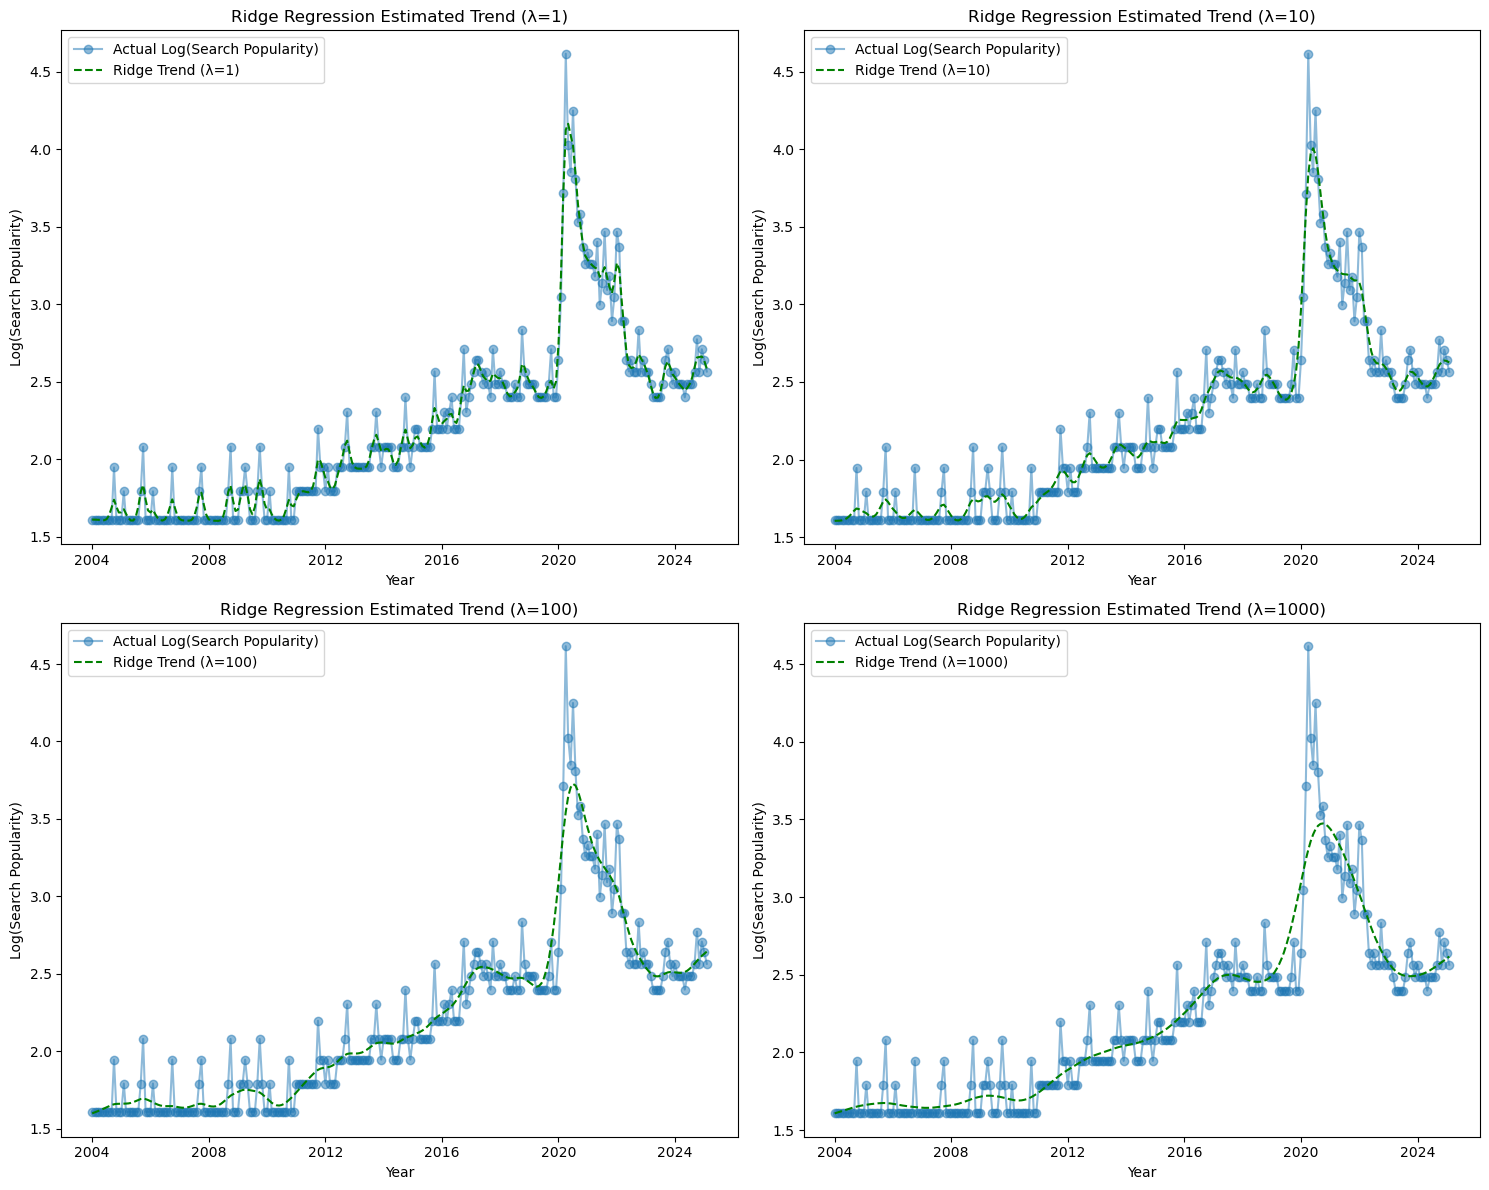

In [221]:
import matplotlib.pyplot as plt

# Define the lambda values to compare
lambda_values = [1, 10, 100, 1000]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 2x2 grid

# Flatten axes array for easy indexing
axes = axes.flatten()

# Generate plots for each lambda value
for i, lam in enumerate(lambda_values):
    ax = axes[i]
    
    # Compute the Ridge trend estimates
    mask["Ridge_Trend"] = X_full @ ridge_estimates[lam]

    # Plot actual log-transformed search popularity
    ax.plot(mask["Month"], mask["Log_Search_Popularity"], label="Actual Log(Search Popularity)", linestyle="-", marker="o", alpha=0.5)

    # Plot Ridge fitted trend
    ax.plot(mask["Month"], mask["Ridge_Trend"], label=f"Ridge Trend (λ={lam})", linestyle="--", color="green")

    # Labels and title
    ax.set_xlabel("Year")
    ax.set_ylabel("Log(Search Popularity)")
    ax.set_title(f"Ridge Regression Estimated Trend (λ={lam})")
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show all plots
plt.show()


#### Interpretation

1.$\lambda = 1$: Almost identical to the OLS model, still capturing too much noise

2.$\lambda = 10$: Slight smoothing, but still allows for short-term fluctuations

3.$\lambda = 100$ Best balance between smoothness and responsiveness

4.$\lambda = 1000$ Overly smoothed, missing some real variations

Best estimate: $\lambda =100$  is the best choice as it captures long-term trends while reducing overfitting.

## 1b)

In [222]:
def solve_lasso(X, y, lambda_val, penalty_start=2):
    """
    Solve Lasso Regression using convex optimization.

    Parameters:
    - X: Design matrix
    - y: Response variable
    - lambda_val: Regularization parameter (λ)
    - penalty_start: Index from which to apply regularization (default=2 to exclude intercept)

    Returns:
    - Estimated coefficients (β)
    """
    n, p = X.shape  # Get matrix dimensions

    # Define variable for coefficients
    beta = cp.Variable(p)

    # Define the Lasso loss function: Least Squares + L1 regularization (Lasso)
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.norm1(beta[penalty_start:])  # L1 norm for sparsity
    objective = cp.Minimize(loss + reg)

    # Solve the convex optimization problem
    prob = cp.Problem(objective)
    prob.solve()

    return beta.value  # Return estimated coefficients

In [223]:
# Define different regularization strengths
lambda_values = [1, 10, 100, 1000]

# Store results for each λ
lasso_estimates = {}

for lam in lambda_values:
    lasso_estimates[lam] = solve_lasso(X_full, y, lambda_val=lam)

# Print Lasso coefficients for λ=100
print(lasso_estimates[100])

[ 1.59033758e+00  2.01531683e-03  3.34196956e-19  2.59814082e-18
  5.92434244e-18  1.02520191e-17  1.55479415e-17  2.17264915e-17
  2.87118341e-17  3.64699333e-17  4.49208812e-17  5.39956789e-17
  6.36349924e-17  7.37721790e-17  8.43527219e-17  9.52937573e-17
  1.06541996e-16  1.18037337e-16  1.29728170e-16  1.41541491e-16
  1.53421077e-16  1.65312182e-16  1.77149809e-16  1.88886450e-16
  2.00475130e-16  2.11848182e-16  2.22958017e-16  2.33764583e-16
  2.44220376e-16  2.54281339e-16  2.63894854e-16  2.73037709e-16
  2.81651952e-16  2.89713494e-16  2.97196352e-16  3.04057198e-16
  3.10268146e-16  3.15810365e-16  3.20664990e-16  3.24801753e-16
  3.28207342e-16  3.30873086e-16  3.32773618e-16  3.33921461e-16
  3.34287979e-16  3.33895539e-16  3.32715353e-16  3.30770101e-16
  3.28063444e-16  3.24594405e-16  3.20386120e-16  3.15445843e-16
  3.09791328e-16  3.03445493e-16  2.96420377e-16  2.88748755e-16
  2.80456136e-16  2.71573512e-16  2.62129548e-16  2.52155355e-16
  2.41693673e-16  2.30776

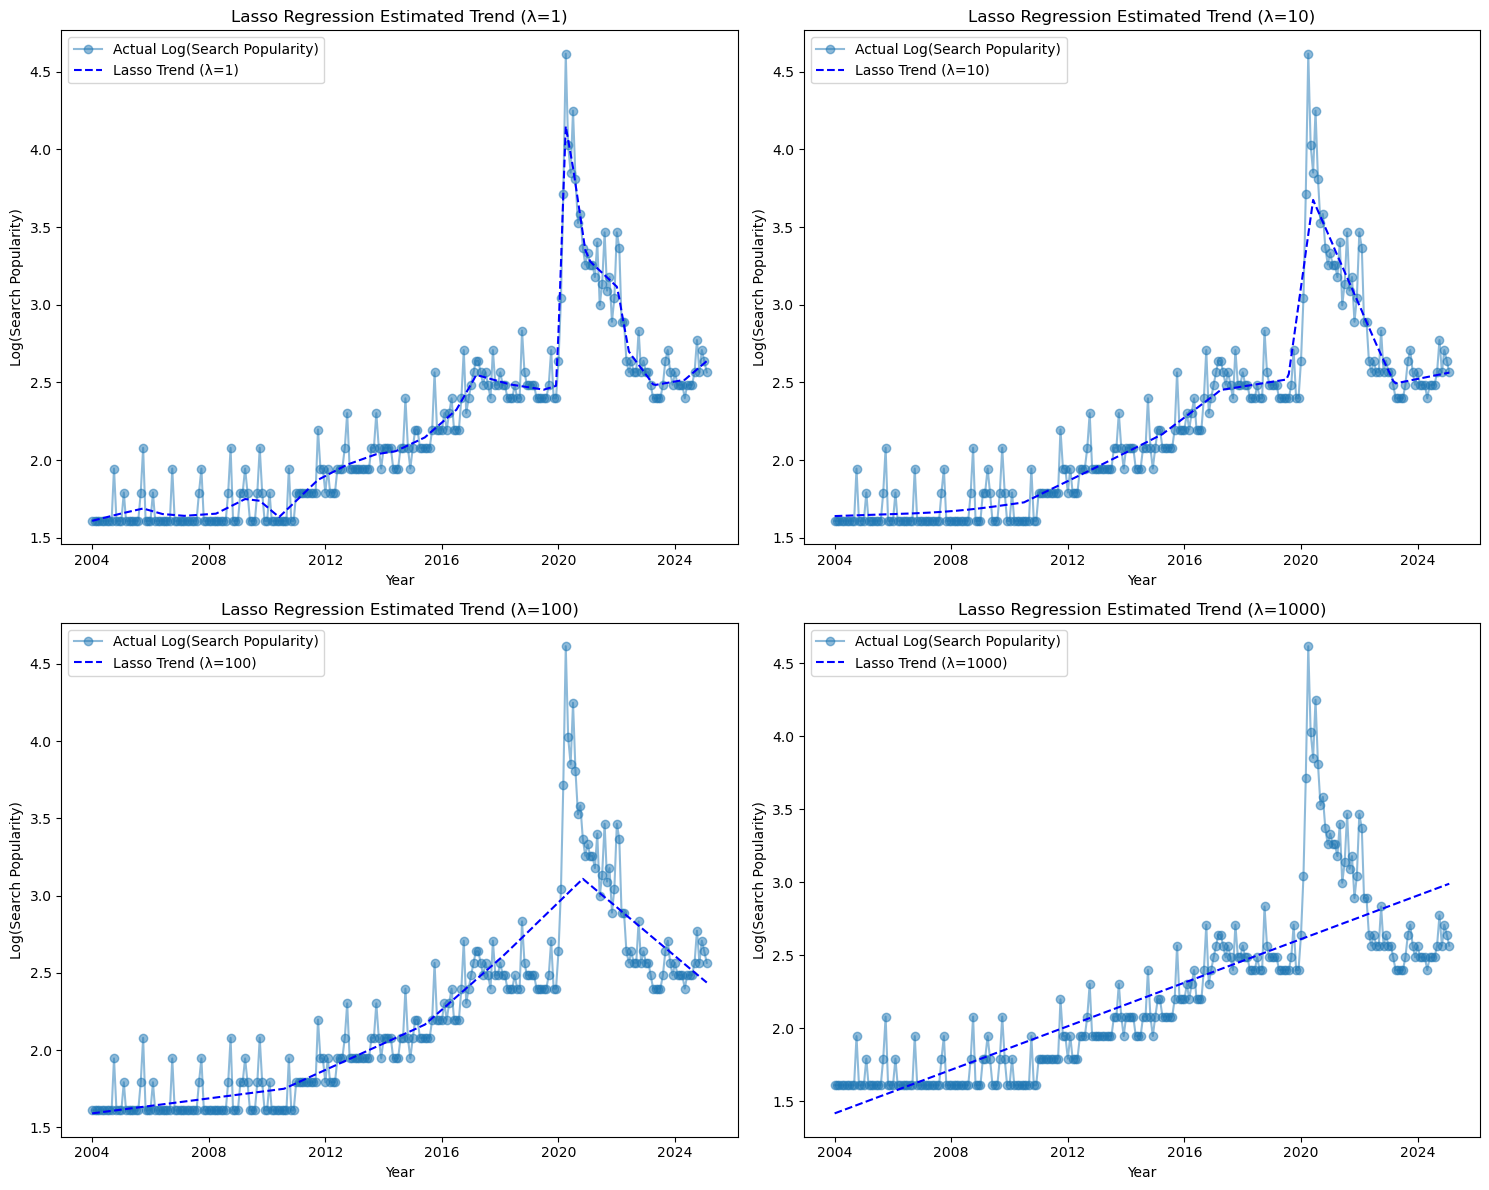

In [224]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 2x2 grid

# Flatten axes array for easy indexing
axes = axes.flatten()

# Generate plots for each lambda value
for i, lam in enumerate(lambda_values):
    ax = axes[i]
    
    # Compute the Lasso trend estimates
    mask["Lasso_Trend"] = X_full @ lasso_estimates[lam]

    # Plot actual log-transformed search popularity
    ax.plot(mask["Month"], mask["Log_Search_Popularity"], label="Actual Log(Search Popularity)", linestyle="-", marker="o", alpha=0.5)

    # Plot Lasso fitted trend
    ax.plot(mask["Month"], mask["Lasso_Trend"], label=f"Lasso Trend (λ={lam})", linestyle="--", color="blue")

    # Labels and title
    ax.set_xlabel("Year")
    ax.set_ylabel("Log(Search Popularity)")
    ax.set_title(f"Lasso Regression Estimated Trend (λ={lam})")
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show all plots
plt.show()

#### Interpretation

The lasso regression results are much more extreme compared to Ridge, which is expected given that Lasso promotes sparsity by setting many coefficients to zero.
    
$\lambda=1$: Still retains flexibility, capturing fluctuations from Ridge.

$\lambda=10$: Begins removing some fluctuations but keeps key shifts.

$\lambda=100$: The trend becomes piecewise linear, with sharp breaks.
    
$\lambda=1000$: Overly simplified, basically the regression is a straight line, it fails to capture the major trend.

Best estimate: $\lambda=10$, appears to provide the best balance capturing key trends and avoiding overfitting.

## 1c)

The best model choice is between Lasso ($\lambda= 10$) and Ridge ($\lambda= 100$), as both effectively capture the key trends in the data. However, Lasso ($\lambda=10$) appears to be the better option. Ridge regression does a good job of preserving overall trends, but it still exhibits small oscillations, especially in regions where the data fluctuates. This suggests that Ridge retains some noise, leading to a less smooth trend line. In contrast, Lasso regression provides a more linear and structured representation of the data’s key changes. It effectively filters out noise while maintaining the most important trend shifts. When considering the objective of this exercise—estimating a smooth trend that avoids both overfitting and underfitting—Lasso ($\lambda=10$) provides the best balance. It captures the overall direction of the data without unnecessary fluctuations, resulting in a more interpretable and robust trend estimation.

## 2a)

In [225]:
fed_min_wage= pd.read_csv("fed_min_wage_data.csv")
fed_min_wage

,observation_date,FEDMINNFRWG
0,1938-10-01,0.25
1,1938-11-01,0.25
2,1938-12-01,0.25
3,1939-01-01,0.25
4,1939-02-01,0.25
...,...,...
1032,2024-10-01,7.25
1033,2024-11-01,7.25
1034,2024-12-01,7.25
1035,2025-01-01,7.25


In [226]:
# Load the dataset
fed_min_wage = pd.read_csv("fed_min_wage_data.csv")

# Rename columns for clarity
fed_min_wage.columns = ["Month", "Min_Wage"]

# Convert "Month" to datetime format
fed_min_wage["Month"] = pd.to_datetime(fed_min_wage["Month"])

# Convert "Min_Wage" to numeric
fed_min_wage["Min_Wage"] = pd.to_numeric(fed_min_wage["Min_Wage"])

# Add a time index (t = 1 for the first month, increasing sequentially)
fed_min_wage["t"] = np.arange(1, len(fed_min_wage) + 1)

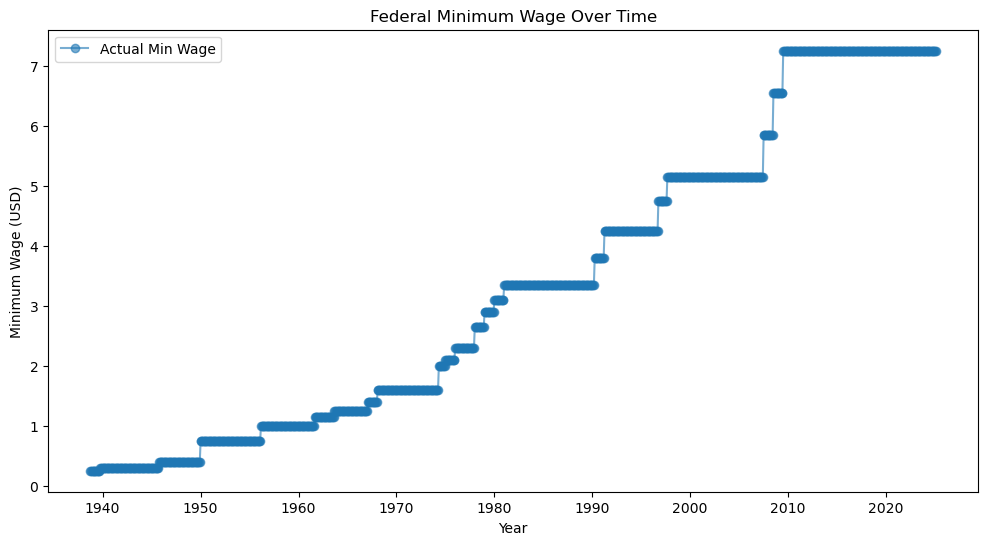

In [227]:
# Plot the original dataset (Minimum Wage over time)
plt.figure(figsize=(12,6))
plt.plot(fed_min_wage["Month"], fed_min_wage["Min_Wage"], marker="o", linestyle="-", label="Actual Min Wage", alpha=0.6)

# Labels and title
plt.xlabel("Year")
plt.ylabel("Minimum Wage (USD)")
plt.title("Federal Minimum Wage Over Time")
plt.legend()

# Show plot
plt.show()

In [228]:
# Define response variable
y = fed_min_wage["Min_Wage"].values

# Construct design matrix X
n = len(fed_min_wage)
X = np.tril(np.ones((n, n), dtype=int))

# Fit the OLS model
unreg_md = sm.OLS(y, X).fit()

# Compute the fitted values
y_pred = unreg_md.fittedvalues

# Construct the design matrix X as a lower triangular matrix
X = np.tril(np.ones((n, n)), k=0)
X_df = pd.DataFrame(X)
print(X_df.head())

   0     1     2     3     4     5     6     7     8     9     ...  1027  \
0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2   1.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3   1.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4   1.0   1.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

   1028  1029  1030  1031  1032  1033  1034  1035  1036  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 1037 columns]


In [229]:
# Display estimated coefficients
print("Estimated β coefficients:")
print(unreg_md.params)

# Compute the first difference of y (y_t+1 - y_t)
print("\nFirst differences of y:")
print(np.diff(y))

# Print the first observation in y (should match β_0)
print("\nFirst observation of y (β_0 estimate):")
print(y[0])

Estimated β coefficients:
[ 2.50000000e-01 -2.02529779e-14  6.23170677e-14 ...  1.54043445e-15
  1.31145095e-15  5.93969318e-15]

First differences of y:
[0. 0. 0. ... 0. 0. 0.]

First observation of y (β_0 estimate):
0.25


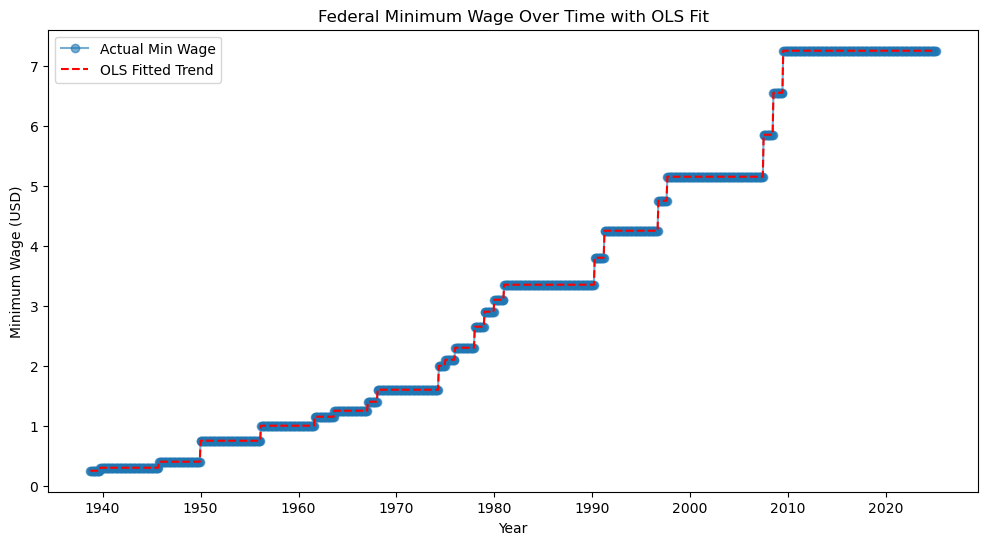

In [230]:
# Plot the original data and the fitted values
plt.figure(figsize=(12,6))
plt.plot(fed_min_wage["Month"], y, marker="o", linestyle="-", label="Actual Min Wage", alpha=0.6)
plt.plot(fed_min_wage["Month"], y_pred, linestyle="--", color="red", label="OLS Fitted Trend")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Minimum Wage (USD)")
plt.title("Federal Minimum Wage Over Time with OLS Fit")
plt.legend()
plt.show()

In [231]:
# Define Ridge regression solver
def solve_ridge(X, y, lambda_val, penalty_start=1):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.sum_squares(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value

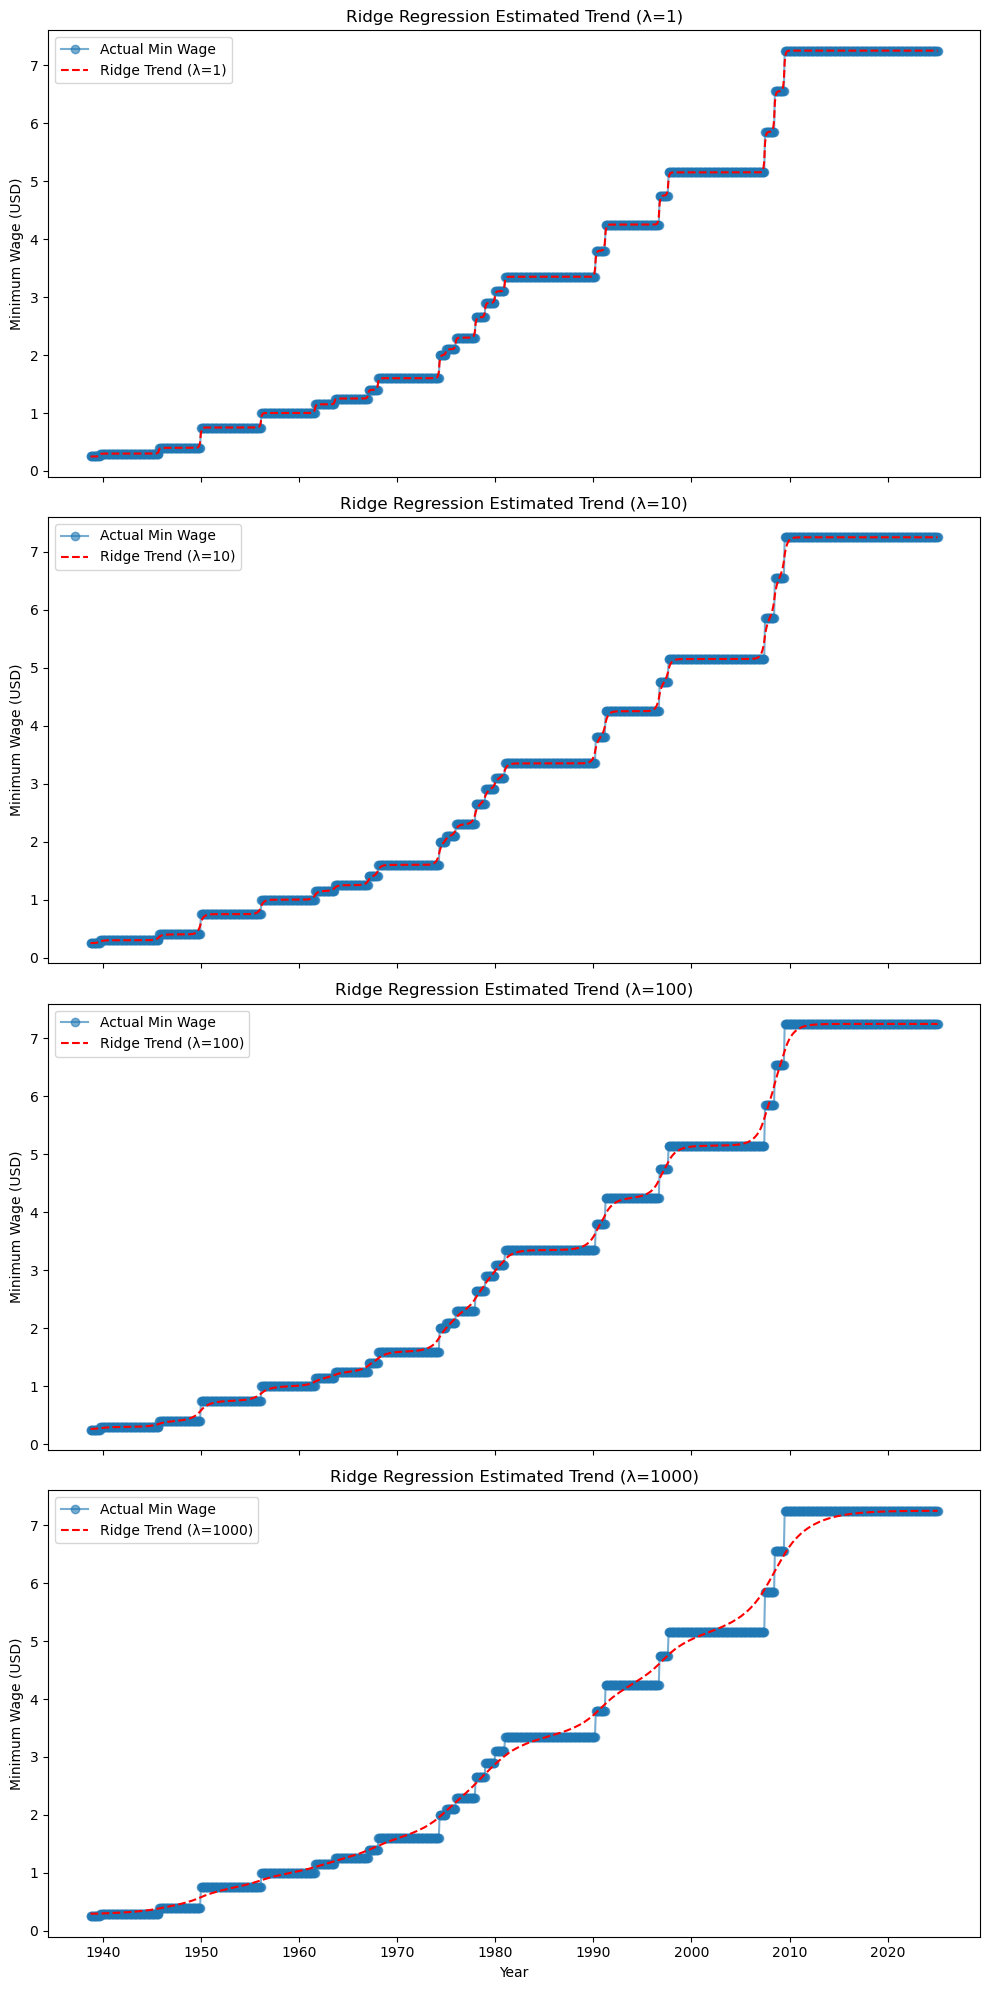

In [232]:
# Create a figure with subplots arranged vertically
fig, axes = plt.subplots(4, 1, figsize=(10, 20), sharex=True)

# Lambda values for ridge regression
lambda_values = [1, 10, 100, 1000]
ridge_predictions = {}  # Store predictions for each lambda

# Plot each ridge regression estimate on a separate subplot
for i, lambda_val in enumerate(lambda_values):
    beta_ridge = solve_ridge(X, y, lambda_val)  # Solve ridge regression
    y_pred_ridge = X @ beta_ridge  # Compute predictions
    ridge_predictions[lambda_val] = y_pred_ridge
    
    axes[i].plot(fed_min_wage["Month"], fed_min_wage["Min_Wage"], marker="o", linestyle="-", alpha=0.6, label="Actual Min Wage")
    axes[i].plot(fed_min_wage["Month"], y_pred_ridge, linestyle="--", color="red", label=f"Ridge Trend (λ={lambda_val})")
    
    axes[i].set_ylabel("Minimum Wage (USD)")
    axes[i].set_title(f"Ridge Regression Estimated Trend (λ={lambda_val})")
    axes[i].legend()

# Add x-label to the last subplot
axes[-1].set_xlabel("Year")

# Display the plots
plt.tight_layout()
plt.show()

#### Interpretation

As expected smaller $\lambda$ values (1 and 10) closely follow the original stepwise structure of minimum wage data, while higher $\lambda$ values (100 and 1000 smooth out trends, reducing the sharp changes.
    
$\lambda=1$ and $\lambda=10$: These fits capture all stepwise jumps in the minimum wage without much deviation

$\lambda=100$: This trend starts to smooth out some minor variations but still preserves the main change points 

$\lambda=1000$: This fit significantly smooths out the stepwise nature of the data, creating a more continuous trend.

This result aligns with expectations: as $\lambda$ increases, the model penalizes abrupt changes more strongly, favoring smoother trends.

Best estimate:$\lambda=1000$ provides a good balance- it smooths out small fluctuations while still capturing major shifts in the trend. This choice helps mitigate overfitting while preserving meaningful changes in the minimum wage over time. It avoids the extreme stepwise jumps seen at lower $\lambda$ values while still reacting reacting appropriately to significant increases. This makes it a strong candidate for summarizing long-term trends without getting lost in short-term variations or over-smoothing the data.

## 2b)

In [233]:
# Define the LASSO function
def solve_lasso(X, y, lambda_val, penalty_start=1):
    n, p = X.shape

    # Define variable
    beta = cp.Variable(p)

    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.norm1(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)

    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()

    return beta.value

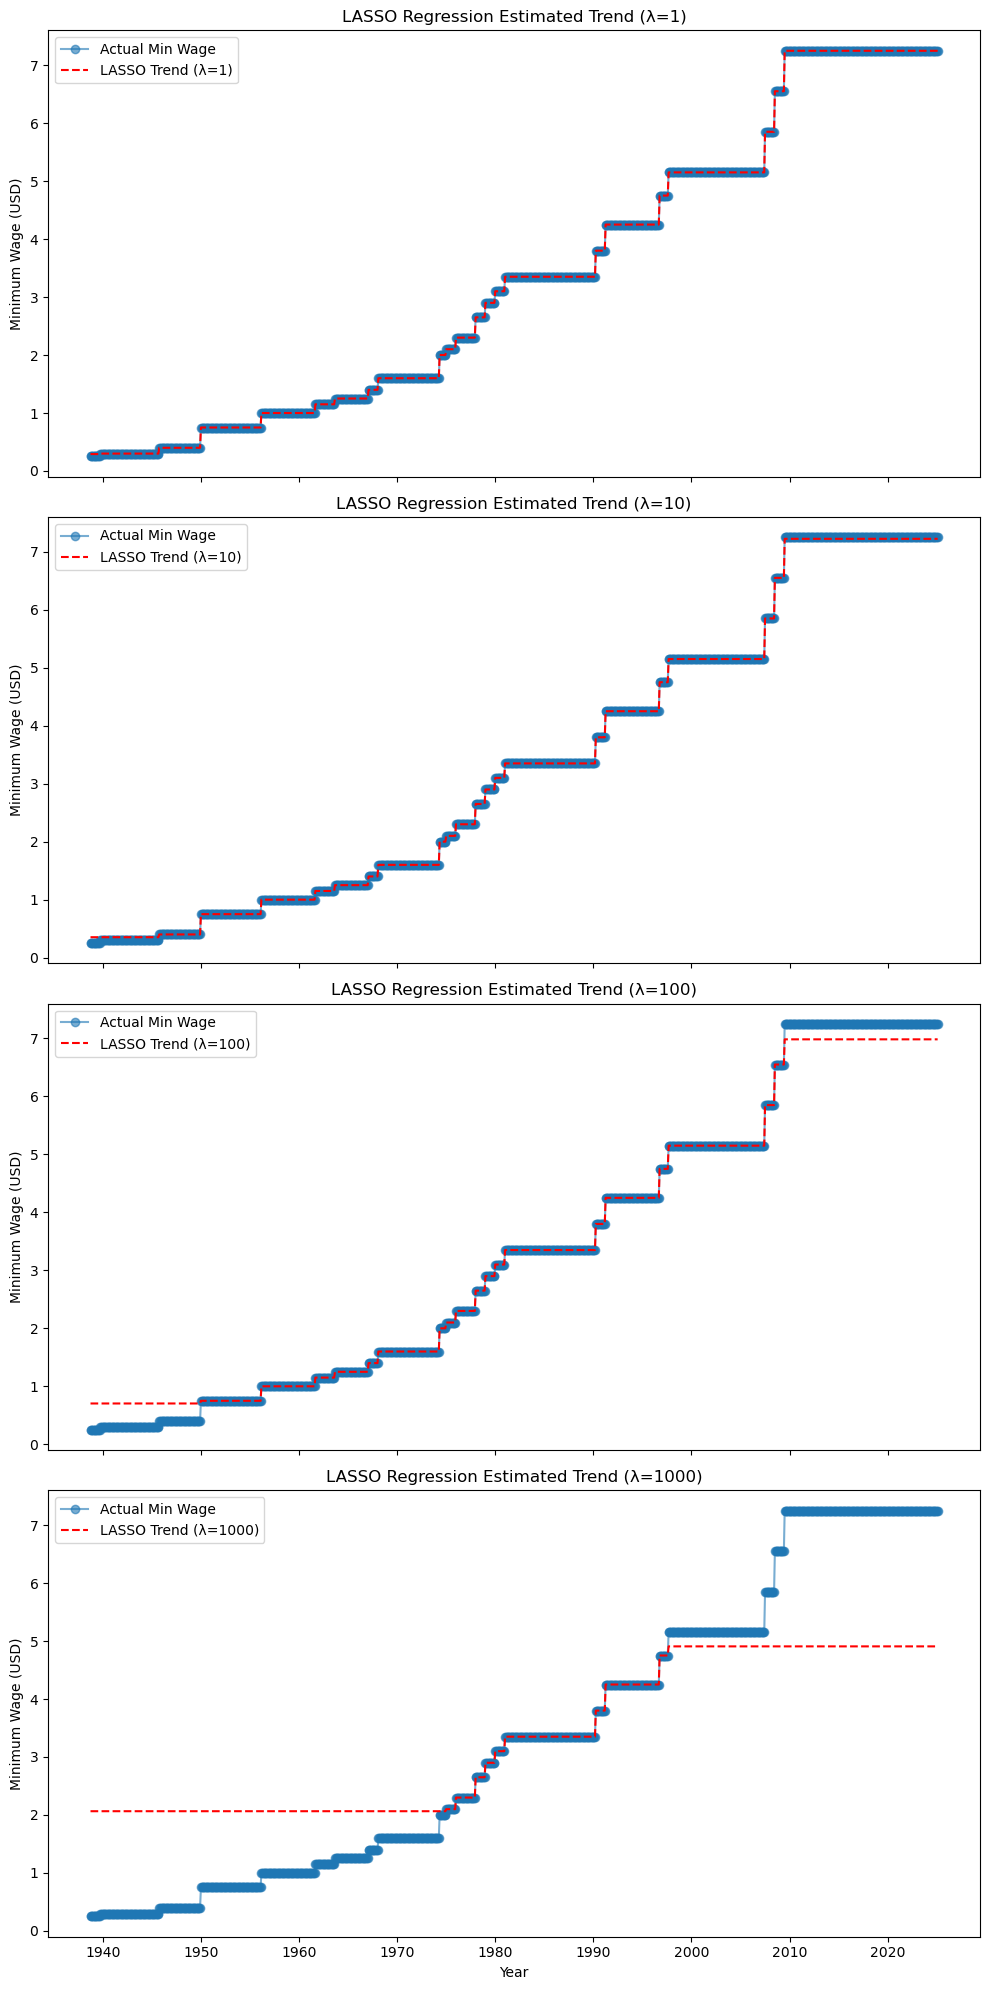

In [234]:
# Define lambda values
lambda_values = [1, 10, 100, 1000]

# Create subplots for stacked visualization
fig, axes = plt.subplots(len(lambda_values), 1, figsize=(10, 20), sharex=True)

# Dictionary to store predictions
lasso_predictions = {}

# Fit and plot LASSO regression for each lambda
for i, lambda_val in enumerate(lambda_values):
    beta_lasso = solve_lasso(X, y, lambda_val)
    y_pred_lasso = X @ beta_lasso
    lasso_predictions[lambda_val] = y_pred_lasso

    axes[i].plot(fed_min_wage["Month"], fed_min_wage["Min_Wage"], marker="o", linestyle="-", alpha=0.6, label="Actual Min Wage")
    axes[i].plot(fed_min_wage["Month"], y_pred_lasso, linestyle="--", color="red", label=f"LASSO Trend (λ={lambda_val})")

    axes[i].set_ylabel("Minimum Wage (USD)")
    axes[i].set_title(f"LASSO Regression Estimated Trend (λ={lambda_val})")
    axes[i].legend()

# Add x-label to the last subplot
axes[-1].set_xlabel("Year")

# Display the plots
plt.tight_layout()
plt.show()

#### Interpretation

As $\lambda$ increases, the LASSO regression applies $L_1$ regularization, which shrinks the coefficients towards zero. This results in a trend estimate that only the most significant changes while ignoring small fluctuations.

$\lambda=1$: The estimated trend closely follows the stepwise structure of the actual minimum wage data. The effect of the regularization is minimal, meaning that most of the coefficients remain nonzero. This model behaves similarly to the OLS, capturing nearly all the changes.

$\lambda=10$: The trend remains largely similar to $\lambda=1$, but some of the smaller, less significant changes start to be smoothed out. The LASSO penalty is beginning to influence the model slightly reducing the number of nonzero coefficients. The key structural changes in the minimum wage are still well-preserved, but minor fluctuations are dampened.

$\lambda=100$: The effect of the regularization is much stronger. Many smaller step changes are now completely removed. The model still captures the major changes in minimum wage but ignore minor intermediate adjustments. 

$\lambda=1000$: The regularization is now extremely strong, causing the model to underfit the data. Most coefficients have been shrunk to zero, meaning that the estimated trend only captures every broad patterns and fails to react to many of the actual policy changes. This model is too simple and does not provide a good fit for the data.

Best estimate:$\lambda=100$ is the best because it smooths out unnecessary fluctuations without loosing critical structural changes in minimum wage trends. It avoids both overfitting (as seen in $\lambda=1$ and $\lambda=10$) and underfitting  ($\lambda=1000$).

## 2c)

I think the ridge regression with $\lambda=100$ is the most suitable for this dataset because it preserves the stepwise structure. The dataset consists of discrete jumps in the minimum wage rather than a smooth continuous trend. The Ridge regression does not aggressively shrink coefficients to zero like LASSO, making it more appropriate for capturing all major changes without forcing sparsity. Compared to OLS, Ridge at $\lambda=100$ effectively smooths the trend while reflecting key policy-driven wage changes. In conclusion, $\lambda=100$ is also the best because it eliminates noise while capturing the key stepwise structure of the dataset. 

## 3a)

Rewriting the objective function:

$$L(\beta_0, \beta_1) = \sum^n_{i=1}(y_1-\beta_0 - \beta_1 x_i)^2 + \lambda \beta_1^2$$

To find the minimizers, take the partial derivatives with respect to $\beta_0$ and $\beta_1$, and set them to zero. Solving for $\beta_0$ we take the derivative with respect to $\beta_0$:

$$\frac{\partial L}{\partial\beta_0} = -2 \sum^n_{i=1} (y_i - \beta_0 - \beta_1 x_i) = 0$$

Since the summation is a linear operator, we can distribute it over the terms inside:

$$-2 \left(\sum^n_{i=1} y_i - \sum^n_{i=1} \beta_0 - \sum^n_{i=1} \beta_1 x_i \right) = 0$$

Since $\beta_0$ is constant, summing it over $n$ terms gives:

$$ \sum^n_{i=1} \beta_0 = n \beta_0 $$

Similarly since $\beta_1$ is also a constant, we can factor it out of the summation:

$$ \sum^n_{i=1} \beta_1 x_i= \beta_1 \sum^n_{i=1} x_i$$

Substituting the results back in our expression:

$$-2 \left(\sum^n_{i=1} y_i -  n \beta_0 - \beta_1 \sum^n_{i=1} \right) x_i=0$$   

Divide by -2:

$$\sum^n_{i=1} y_i -  n \beta_0 - \beta_1 \sum^n_{i=1} x_i=0$$   

Rearrange:

$$ n \beta_0= \sum^n_{i=1}y_i -\beta_1 \sum^n_{i=1} x_i$$

Divide by $n$:

$$\beta_0= \frac{1}{n}\sum^n_{i=1}y_i -\frac{1}{n}\beta_1 \sum^n_{i=1} x_i$$

Recall, $\bar{y} = \frac{1}{n} \sum^n_{i=1} y_i$ and $\bar{x} = \frac{1}{n}\sum^n_{i=1}x_i$, we get:

$$\beta_0 = \bar{y} - \beta_1 \bar{x}$$

Solving for $\beta_1$. Take the derivative with respect to $\beta_1$:

$$\frac{\partial L}{\partial \beta_1} = -2 \sum^n_{i=1} x_i (y_i - \beta_0 - \beta_1 x_i) + 2 \lambda \beta_1 = 0$$

Substituting $\beta_0 = \bar{y} - \beta_1 \bar{x}$:

$$\sum^n_{i=1}x_i(y_i - (\bar{y}- \beta_1 \bar{x}) - \beta_1 x_i) + \lambda \beta_1= 0$$

Distribute the summation and rearrange:

$$\sum^n_{i=1}x_i y_i - \sum^n_{i=1}x_i(\bar{y} - \beta_1 \bar{x}) - \sum^n_{i=1}x_i \beta_1 x_i + \lambda \beta_1 = 0$$

Distribute the summation across the terms inside the second summation:

$$\sum^n_{i=1}x_i y_i - \sum^n_{i=1}x_i\bar{y} + \sum^n_{i=1}x_i \beta_1 \bar{x} - \sum^n_{i=1}x_i \beta_1 x_i + \lambda \beta_1 = 0$$

Factor out constants, $\beta_1$, $\bar{x}$, and $\bar{y}$:

$$\sum^n_{i=1}x_i y_i - \bar{y} \sum^n_{i=1}x_i + \beta_1 \bar{x} \sum^n_{i=1}x_i - \beta_1 \sum^n_{i=1}x_i^2 + \lambda \beta_1 = 0$$

Isolate $\beta_1$ by rearranging the terms:

$$\sum^n_{i=1}x_i y_i - \bar{y} \sum^n_{i=1}x_i=\beta_1 \sum^n_{i=1}x_i^2 - \beta_1 \bar{x} \sum^n_{i=1}x_i + \lambda \beta_1$$

Factor $\beta_1$ out of the RHS:

$$\sum^n_{i=1}x_i y_i - \bar{y} \sum^n_{i=1}x_i = \beta_1 \left( \sum^n_{i=1}x_i^2 - \bar{x} \sum^n_{i=1}x_i + \lambda \right)$$

Solve $\beta_1$ by dividing both sides by the coefficient of $\beta_1$:

$$\beta_1 = \frac{\sum^n_{i=1}x_i y_i - \bar{y} \sum^n_{i=1}x_i}{ \sum^n_{i=1}x_i^2 - \bar{x} \sum^n_{i=1}x_i + \lambda}$$

Recall $\bar{y} = \frac{1}{n} \sum^n_{i=1} y_i$, we rewrite:

$$\sum^n_{i=1} x_i y_i - \frac{1}{n} \sum^n_{i=1}y_i \sum^n_{i=1} x_i \rightarrow  \sum^n_{i=1} x_i y_i - \sum^n_{i=1} \bar{x}y_i \rightarrow \sum^n_{i=1} (x_i - \bar{x})y_i \rightarrow 
\sum^n_{i=1} (x_i - \bar{x})((y_i - \bar{y}) + \bar{y}) \rightarrow \sum^n_{i=1} (x_i - \bar{x})(y_i - \bar{y}) + \sum^n_{i=1}(x_i - \bar{x})\bar{y}$$

Factor out $\bar{y}$ in second term:

$$\sum^n_{i=1} (x_i - \bar{x})(y_i - \bar{y}) + \bar{y}\sum^n_{i=1}(x_i - \bar{x})$$

Recall, $\sum^n_{i=1} (x_i - \bar{x}) = 0$. Thus the right term cancels out:

$$\sum^n_{i=1} (x_i - \bar{x})(y_i - \bar{y})$$

Now, for the denominator:

$$ \sum^n_{i=1}x_i^2 - \bar{x} \sum^n_{i=1}x_i + \lambda$$

Recall, $\sum^n_{i=1} x_i = n \bar{x}$, substitute:

$$\sum^n_{i=1}x_i^2 - n \bar{x}^2 + \lambda$$

Recall, $\sum^n_{i=1}x_i^2 - n \bar{x}^2 = \sum^n_{i=1}(x_i -\bar{x})^2$, and substitute:

$$\sum^n_{i=1}(x_i -\bar{x})^2+ \lambda$$

Combining the numerator and denominator:

$$\beta_1^{ridge} (\lambda)= \frac{\sum^n_{i=1} (x_i - \bar{x})(y_i - \bar{y})}{\lambda + \sum^n_{i=1}(x_i -\bar{x})^2}$$ 

Lastly, recall our definition for $\beta_0$ and substitute $\beta_1$:

$$\beta_0^{ridge} (\lambda) = \bar{y} - \bar{x}\beta_1^{ridge} (\lambda)$$

## 3b)

Similar to Ridge, we start by writing out the loss function including the penalty:

$$ L(\beta_0, \beta_1)= \sum^n_{i=1} (y_i - \beta_0 - \beta_1 x_i)^2 + \lambda |\beta_1|$$

Just like in Ridge regression, take the derivative of the loss function with respect to $\beta_0$ and solve:

$$\sum^n_{i=1} (y_i - \beta_0 - \beta_1 x_i)^2 =0$$

Note: the LASSO estimator for $\beta_0$ follows the same form as Ridge. Please refer to 3a to see how the result is derived.

$$\beta_0 = \bar{y} - \bar{x}\beta_1$$

Substitute $\beta_0$ into the loss function and expand:

$$\sum^n_{i=1} (y_i - (\bar{y} - \bar{x}\beta_1) - \beta_1 x_i)^2 + \lambda |\beta_1| \rightarrow \sum^n_{i=1} (y_i - \bar{y} -\beta_1(x_i+ \bar{x})^2 + \lambda |\beta_1|$$



Differentiate with respect to $\beta_1$:

$$\frac{dL}{d\beta_1} = -2 \sum_{i=1}^{n} (y_i - \bar{y})(x_i - \bar{x}) + 2\beta_1 \sum_{i=1}^{n} (x_i - \bar{x})^2 + \lambda \cdot (\beta_1)$$

Setting the derivative to zero:

$$-2 \sum_{i=1}^{n} (y_i - \bar{y})(x_i - \bar{x}) + 2\beta_1 \sum_{i=1}^{n} (x_i - \bar{x})^2 + \lambda \cdot \text{sign}(\beta_1) = 0$$

Dividing everything by 2:

$$-\sum_{i=1}^{n} (y_i - \bar{y})(x_i - \bar{x}) + \beta_1 \sum_{i=1}^{n} (x_i - \bar{x})^2 + \frac{\lambda}{2} \text{sign}(\beta_1) = 0$$

Rearranging for $\beta_1$:

$$\beta_1 \sum_{i=1}^{n} (x_i - \bar{x})^2 = \sum_{i=1}^{n} (y_i - \bar{y})(x_i - \bar{x}) - \frac{\lambda}{2} \text{sign}(\beta_1)$$

Divide by $\beta_1$'s coefficient:

$$\beta_1 =\frac{\sum_{i=1}^{n} (y_i - \bar{y})(x_i - \bar{x}) - \frac{\lambda}{2} \text{sign}(\beta_1)}{\sum_{i=1}^{n} (x_i - \bar{x})^2}$$

Where: $$\text{sign}(x) =
\begin{cases} 
1 & \text{if } x > 0 \\
0 & \text{if } x = 0 \\
-1 & \text{if } x < 0
\end{cases}$$

Note: In the context of the LASSO regression, the sign function appears because of the $L_1$ regularization term $\lambda|\beta_1|$. This function behaves differently depending on whether $\beta_1$ is positive, negative, or exactly zero, which is why LASSO forces some coefficients to become exactly zero when $\lambda$ is large enough. More formally, we can apply soft thresholding:

If $\lambda(y_i - \bar{y})(x_i - \bar{x}) > \frac{\lambda}{2}$, then:

$$\beta_1 =\frac{\sum_{i=1}^{n} (y_i - \bar{y})(x_i - \bar{x}) - \frac{\lambda}{2}}{\sum_{i=1}^{n} (x_i - \bar{x})^2}$$

If $\lambda(y_i - \bar{y})(x_i - \bar{x}) < -\frac{\lambda}{2}$, then:

$$\beta_1 =\frac{\sum_{i=1}^{n} (y_i - \bar{y})(x_i - \bar{x}) + \frac{\lambda}{2}}{\sum_{i=1}^{n} (x_i - \bar{x})^2}$$

If $\lambda(y_i - \bar{y})(x_i - \bar{x}) \leq -\frac{\lambda}{2}$, then:

$$\beta_0 = 0$$

Lastly, substituting $\beta_1^{lasso}$ into our $\beta_0$ result:

$$\hat{\beta_0}^{lasso} = \bar{y} - \bar{x}\hat{\beta_1}^{lasso}$$

## 4a)

In [2]:
# Load the actual Yahoo dataset
yahoo = pd.read_csv("yahoo_query.csv")

# Drop the first row, which contains the misplaced column headers
yahoo = yahoo.iloc[1:].reset_index(drop=False)
print(yahoo)
# Rename columns for clarity
yahoo.columns = ["Month", "Search_Popularity"]

# Convert "Month" column to datetime format
yahoo["Month"] = pd.to_datetime(yahoo["Month"])
yahoo["Search_Popularity"] = pd.to_numeric(yahoo["Search_Popularity"])

       index Category: All categories
0    2004-01                       40
1    2004-02                       39
2    2004-03                       41
3    2004-04                       40
4    2004-05                       42
..       ...                      ...
248  2024-09                       18
249  2024-10                       18
250  2024-11                       17
251  2024-12                       17
252  2025-01                       16

[253 rows x 2 columns]


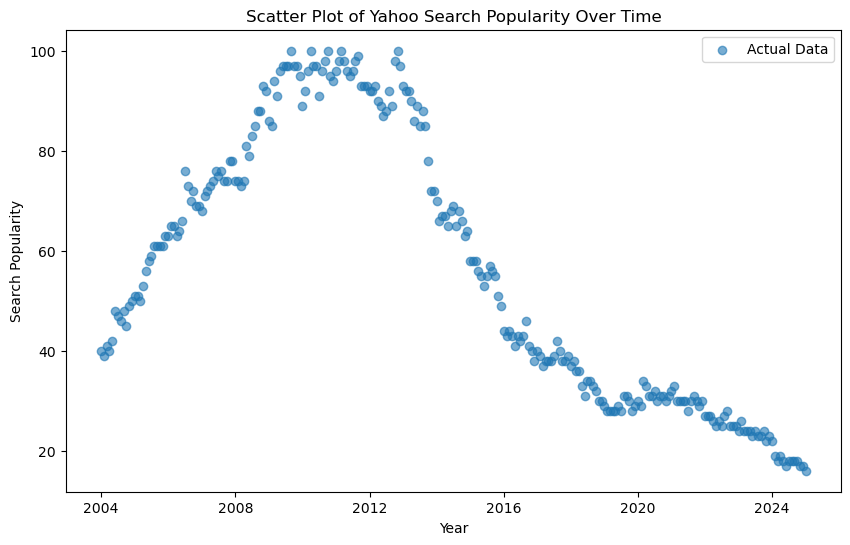

In [3]:
# Scatter plot of the original dataset
plt.figure(figsize=(10, 6))
plt.scatter(yahoo["Month"], yahoo["Search_Popularity"], alpha=0.6, label="Actual Data")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Search Popularity")
plt.title("Scatter Plot of Yahoo Search Popularity Over Time")
plt.legend()
plt.show()

In [4]:
y = yahoo["Search_Popularity"].values  # Response variable
n = len(y)  # Number of observations

# Construct the design matrix X_full
x = np.arange(1, n+1)  # Time index starting from 1
X_full = np.column_stack([np.ones(n), x - 1])  # First two columns: intercept and time index

# Add the hinge terms (t - k)+
for i in range(n-2):
    c = i + 2
    xc = ((x > c).astype(float)) * (x - c)  # Hinge function max(t - c, 0)
    X_full = np.column_stack([X_full, xc])
print(X_full)

[[  1.   0.  -0. ...  -0.  -0.  -0.]
 [  1.   1.   0. ...  -0.  -0.  -0.]
 [  1.   2.   1. ...  -0.  -0.  -0.]
 ...
 [  1. 250. 249. ...   1.   0.  -0.]
 [  1. 251. 250. ...   2.   1.   0.]
 [  1. 252. 251. ...   3.   2.   1.]]


In [5]:
mdfull = sm.OLS(y, X_full).fit()
print(mdfull.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 15 Mar 2025   Prob (F-statistic):                nan
Time:                        18:57:33   Log-Likelihood:                 5478.6
No. Observations:                 253   AIC:                        -1.045e+04
Df Residuals:                       0   BIC:                            -9557.
Df Model:                         252                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.0000        inf          0        n

/srv/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/srv/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/srv/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In [6]:
print(y[0])
print(y[1] - y[0])
print(y[2] - y[1] - y[1] + y[0])

40
-1
3


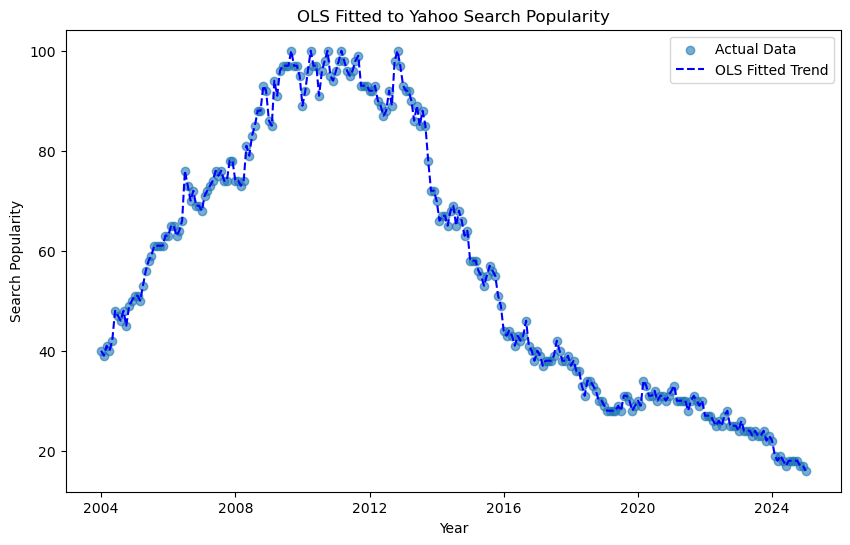

In [7]:
X_ols = X_full  # Use the same design matrix
ols_model = sm.OLS(y, X_ols).fit()
y_pred_ols = ols_model.predict(X_ols)

# Plot the data with OLS and Ridge regression fits
plt.figure(figsize=(10, 6))
plt.scatter(yahoo["Month"], y, label="Actual Data", alpha=0.6)
plt.plot(yahoo["Month"], y_pred_ols, color="blue", linestyle="--", label="OLS Fitted Trend")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Search Popularity")
plt.title("OLS Fitted to Yahoo Search Popularity")
plt.legend()
plt.show()

In [8]:
def solve_ridge(X, y, lambda_val, penalty_start=2):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.sum_squares(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value

In [9]:
b_ridge = solve_ridge(X_full, y, lambda_val = 100000)
print(b_ridge)

[ 4.15186674e+01  8.90711616e-01 -1.51866735e-05 -6.44671367e-05
 -1.36748354e-04 -2.50936645e-04 -3.95936961e-04 -5.20651746e-04
 -6.43979483e-04 -7.84813448e-04 -9.32040480e-04 -1.12453957e-03
 -1.33118038e-03 -1.55082133e-03 -1.78230755e-03 -2.03446862e-03
 -2.32611634e-03 -2.63604213e-03 -2.94301417e-03 -3.23577428e-03
 -3.51303484e-03 -3.76347587e-03 -3.99574227e-03 -4.21844130e-03
 -4.44014026e-03 -4.64936428e-03 -4.85459406e-03 -5.04426384e-03
 -5.22675930e-03 -5.43041566e-03 -5.65351589e-03 -5.88428867e-03
 -6.03090611e-03 -6.13148150e-03 -6.22406783e-03 -6.29665674e-03
 -6.38717767e-03 -6.50349706e-03 -6.66341751e-03 -6.84467655e-03
 -7.04494509e-03 -7.26182562e-03 -7.49285014e-03 -7.72547805e-03
 -7.97709383e-03 -8.24500469e-03 -8.55643807e-03 -8.91853897e-03
 -9.29836682e-03 -9.70289187e-03 -1.01789914e-02 -1.07334456e-02
 -1.13829329e-02 -1.21240244e-02 -1.28931775e-02 -1.37167281e-02
 -1.45608834e-02 -1.54117133e-02 -1.62451422e-02 -1.70669401e-02
 -1.78327150e-02 -1.85579

In [10]:
def ridge_cv(X, y, lambda_candidates):
    n = len(y)
    folds = []
    for i in range(5):
        test_indices = np.arange(i, n, 5)
        train_indices = np.array([j for j in range(n) if j % 5 != i])
        folds.append((train_indices, test_indices))
    cv_errors = {lamb: 0 for lamb in lambda_candidates}

    for train_index, test_index in folds:
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        for lamb in lambda_candidates:
            beta = solve_ridge(X_train, y_train, lambda_val = lamb)
            y_pred = np.dot(X_test, beta)
            squared_errors = (y_test - y_pred) ** 2
            cv_errors[lamb] += np.sum(squared_errors)
    for lamb in lambda_candidates:
        cv_errors[lamb] /= n
        
    best_lambda = min(cv_errors, key = cv_errors.get)

    return best_lambda, cv_errors

In [11]:
lambda_candidates = np.array([0.1, 1, 10, 100, 1000, 10000, 100000])
print(lambda_candidates)

best_lambda, cv_errors = ridge_cv(X_full, y, lambda_candidates)
print(best_lambda)
print("CV errors for each lambda:")
for lamb, error in sorted(cv_errors.items()):
    print(f"Lambda = {lamb:.2f}, CV Error = {error:.6f}")

[1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05]
0.1
CV errors for each lambda:
Lambda = 0.10, CV Error = 3.477439
Lambda = 1.00, CV Error = 3.522831
Lambda = 10.00, CV Error = 4.272680
Lambda = 100.00, CV Error = 5.346427
Lambda = 1000.00, CV Error = 7.006783
Lambda = 10000.00, CV Error = 9.116044
Lambda = 100000.00, CV Error = 16.296988


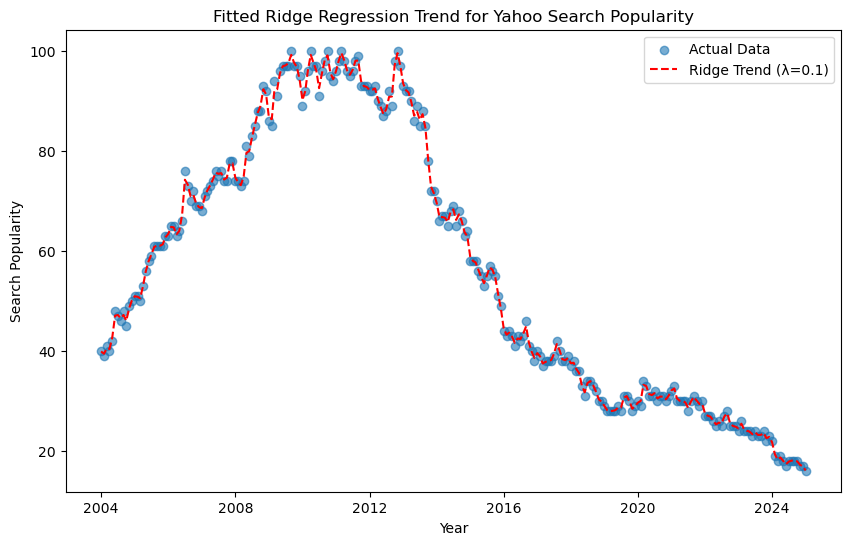

In [12]:
# Fit the ridge regression model using the best lambda
best_lambda = 0.1  # From cross-validation results
b_ridge = solve_ridge(X_full, y, best_lambda)

# Compute the fitted values
y_pred_ridge = X_full @ b_ridge

# Plot the actual data and the fitted ridge regression trend
plt.figure(figsize=(10, 6))
plt.scatter(yahoo["Month"], y, label="Actual Data", alpha=0.6)
plt.plot(yahoo["Month"], y_pred_ridge, color='red', label=f'Ridge Trend (λ={best_lambda})', linestyle="--")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Search Popularity")
plt.title("Fitted Ridge Regression Trend for Yahoo Search Popularity")
plt.legend()
plt.show()

## Interpretation

From the cross-validation results, we found that the best regularization parameter was $\lambda=0.1$. When we compare this ridge regression model to the OLS model, we observe that they produce very similar fits. This suggests that the penalty term in ridge regression is too small to meaningfully alter fit. Since $\lambda=0.1$ is a very small regularization parameter, the ridge model behaves almost identically to OLS. The ridge penalty is not strong enough to significantly shrink the coefficients or smooth out fluctuations in the fitted values. The fitted trend still closely follows the actual data, similar to OLS. This suggests that ridge regression is not providing much additonal bias in exchange for variance reduction, meaning we might still be overfitting to some degree.

## 4bi)

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Define prior parameters
C = 10**4
tau_gr = np.logspace(np.log10(0.001), np.log10(2), 150)  # Prior for tau
sig_gr = np.logspace(np.log10(0.5), np.log10(10), 150)  # Prior for sigma

# Generate a meshgrid for tau and sigma
t, s = np.meshgrid(tau_gr, sig_gr)
g = pd.DataFrame({'tau': t.flatten(), 'sig': s.flatten()})

# Define response variable and design matrix
y = yahoo["Search_Popularity"].values
n = len(y)
x = np.arange(1, n+1)
X_full = np.column_stack((np.ones(n), x))  # First two columns: intercept and time index

# Add the hinge terms (t - k)+
for i in range(n - 2):
    c = i + 2
    xc = ((x > c).astype(float)) * (x - c)  # Hinge function max(t - c, 0)
    X_full = np.column_stack([X_full, xc])

# Precompute XTX and its inverse (to avoid redundant calculations)
XTX = np.dot(X_full.T, X_full)

# Function to compute the log posterior
def compute_logpost(i):
    tau = g.loc[i, 'tau']
    sig = g.loc[i, 'sig']

    # Construct covariance matrix
    Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, X_full.shape[1] - 2)]))
    Mat = np.linalg.inv(Q + XTX / (sig**2) + 1e-6 * np.eye(Q.shape[0]))  # Use stabilization term

    # Compute log determinant terms
    _, logdetQ = np.linalg.slogdet(Q)
    _, logdetXTX = np.linalg.slogdet(XTX)

    # Compute log posterior
    logpost = (-n / 2) * np.log(sig) - np.log(tau) - 0.5 * logdetXTX + 0.5 * logdetQ

    return logpost

# Run computations in parallel
g['logpost'] = Parallel(n_jobs=-1)(delayed(compute_logpost)(i) for i in range(len(g)))

# Normalize log posterior for proper posterior weights
g['post'] = np.exp(g['logpost'] - np.max(g['logpost']))  # Avoid numerical underflow
g['post'] /= np.sum(g['post'])  # Normalize

# Find optimal estimates by maximizing posterior
max_row = g['logpost'].idxmax()
tau_opt = g.loc[max_row, 'tau']
sig_opt = g.loc[max_row, 'sig']
ratio_opt = sig_opt**2 / tau_opt**2

# Display results
results = {
    "Optimal tau": tau_opt,
    "Optimal sigma": sig_opt,
    "Ratio (sigma^2 / tau^2)": ratio_opt
}
print(results)

{'Optimal tau': np.float64(2.0), 'Optimal sigma': np.float64(0.5), 'Ratio (sigma^2 / tau^2)': np.float64(0.0625)}


## 4bii)

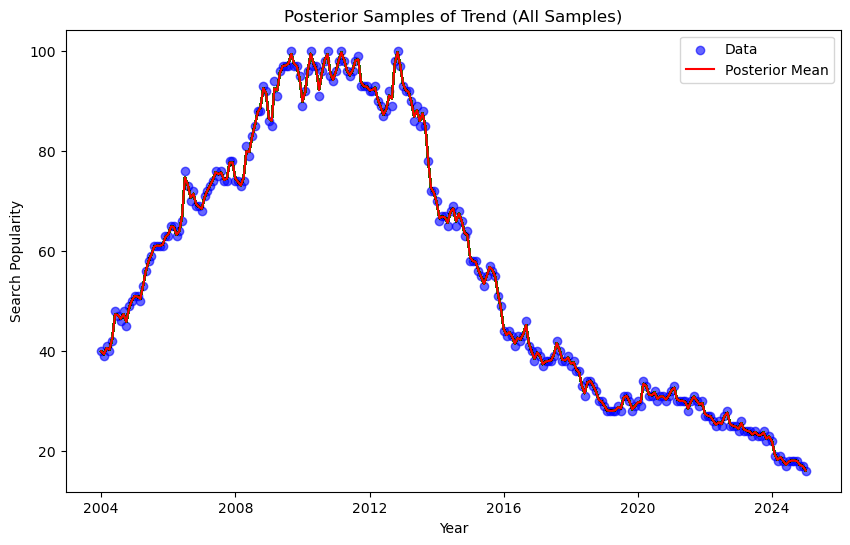

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

N = 1000  # Number of posterior samples

# Sample posterior values correctly
samples = g.sample(N, weights='post', replace=True).to_numpy()
tau_samples = np.array(samples[:, 0])
sig_samples = np.array(samples[:, 1])

# Precompute XTX outside the loop for efficiency
XTX = np.dot(X_full.T, X_full)

# Function to compute posterior samples
def compute_posterior(i):
    tau = tau_samples[i]
    sig = sig_samples[i]

    # Construct Q matrix with regularization
    Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, X_full.shape[1] - 2)]))

    # Compute TempMat using pseudo-inverse for stability
    TempMat = np.linalg.pinv(np.linalg.pinv(Q) + (XTX / (sig**2)))

    # Compute posterior beta_hat and mu_hat
    XTy = np.dot(X_full.T, y)
    beta_hat = np.dot(TempMat, XTy / (sig**2))
    mu_hat = np.dot(X_full, beta_hat)

    return mu_hat

# Run computations in parallel
muhats = np.array(Parallel(n_jobs=-1)(delayed(compute_posterior)(i) for i in range(N)))

# Compute posterior mean
mu_est = np.mean(muhats, axis=0)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(yahoo["Month"], y, label="Data", alpha=0.6, color="blue")

# Plot all posterior samples
for i in range(N):  
    plt.plot(yahoo["Month"], muhats[i], color='green', alpha=0.05)  # Use low alpha to visualize density

# Plot posterior mean
plt.plot(yahoo["Month"], mu_est, color='red', label="Posterior Mean")

plt.legend()
plt.title("Posterior Samples of Trend (All Samples)")
plt.xlabel("Year")
plt.ylabel("Search Popularity")
plt.show()

#### Comments

The posterior samples are tightly clustered around the posterior mean, suggesting the model has low uncertainty in estimating the trend.
If the samples were highly dispersed, it would indicate greater model uncertainty, which is not the case here. The model assigns higher confidence to trend estimates where data is densely populated, as seen by the minimal spread in the posterior samples.
If there were missing data or high noise levels, the spread of samples would increase, reflecting greater uncertainty.The uncertainty remains relatively stable over time, which suggests the model has learned a strong global structure in the trend.
If there were sudden jumps or variability in posterior samples, it might indicate data regions where the model struggles to make confident predictions.

## 4biii)

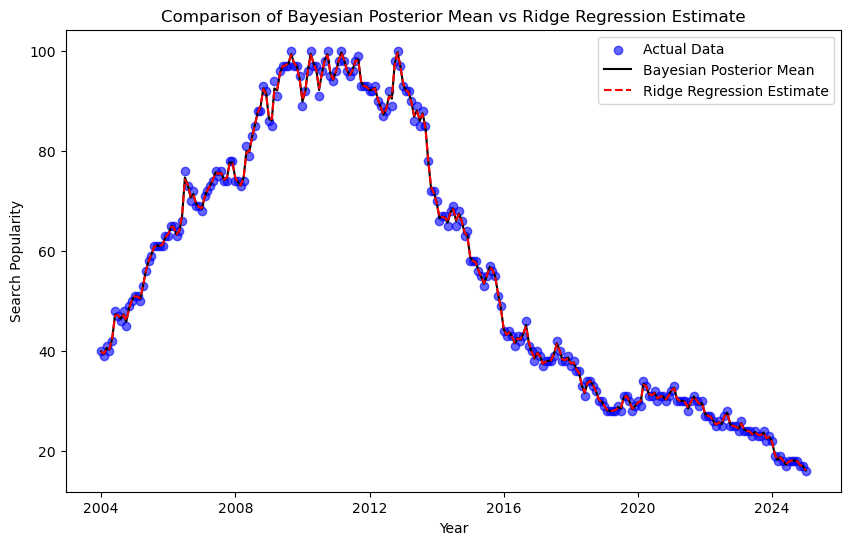

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the Bayesian posterior mean estimate
mu_bayes_est = np.mean(muhats, axis=0)  # Average over posterior samples

# Plot the actual data
plt.figure(figsize=(10, 6))
plt.scatter(yahoo["Month"], y, label="Actual Data", alpha=0.6, color="blue")

# Plot the Bayesian posterior mean estimate
plt.plot(yahoo["Month"], mu_bayes_est, color="black", label="Bayesian Posterior Mean")

# Plot Ridge Regression estimate from part (a)
plt.plot(yahoo["Month"], y_pred_ridge, color="red", linestyle="--", label="Ridge Regression Estimate")

# Labels and legend
plt.xlabel("Year")
plt.ylabel("Search Popularity")
plt.title("Comparison of Bayesian Posterior Mean vs Ridge Regression Estimate")
plt.legend()
plt.show()

#### Comments

The Bayesian posterior mean (black line) and the Ridge regression estimate (red dashed line) are nearly identical.
Both methods effectively capture the trend in Yahoo's search popularity over time. The Ridge regression estimate appears to be slightly smoother than the Bayesian posterior mean.
This makes sense because Ridge regression directly applies an L2 penalty to coefficients, promoting smoothness.
The Bayesian estimate, derived from posterior samples, captures a similar structure but may exhibit minor variability due to sampling effects. The Bayesian approach provides a probabilistic framework, allowing uncertainty quantification in trend estimation.
Ridge regression is purely deterministic and provides a single-point estimate without uncertainty information.

## 5a)

In [75]:
golf= pd.read_csv("golf_data.csv")
golf

,Category: All categories
Month,golf: (United States)
2004-01,45
2004-02,51
2004-03,65
2004-04,77
...,...
2024-10,41
2024-11,36
2024-12,38
2025-01,35


In [76]:
# Load the dataset
golf = pd.read_csv("golf_data.csv")

# Drop the first row (which contains misplaced column headers)
golf = golf.iloc[1:].reset_index(drop=False)

# Rename columns for clarity
golf.columns = ["Month", "Search_Popularity"]

# Convert "Month" column to datetime format
golf["Month"] = pd.to_datetime(golf["Month"])
golf["Search_Popularity"] = pd.to_numeric(golf["Search_Popularity"])

y = golf["Search_Popularity"].values

# Check the data
golf

,Month,Search_Popularity
0,2004-01-01,45
1,2004-02-01,51
2,2004-03-01,65
3,2004-04-01,77
4,2004-05-01,81
...,...,...
249,2024-10-01,41
250,2024-11-01,36
251,2024-12-01,38
252,2025-01-01,35


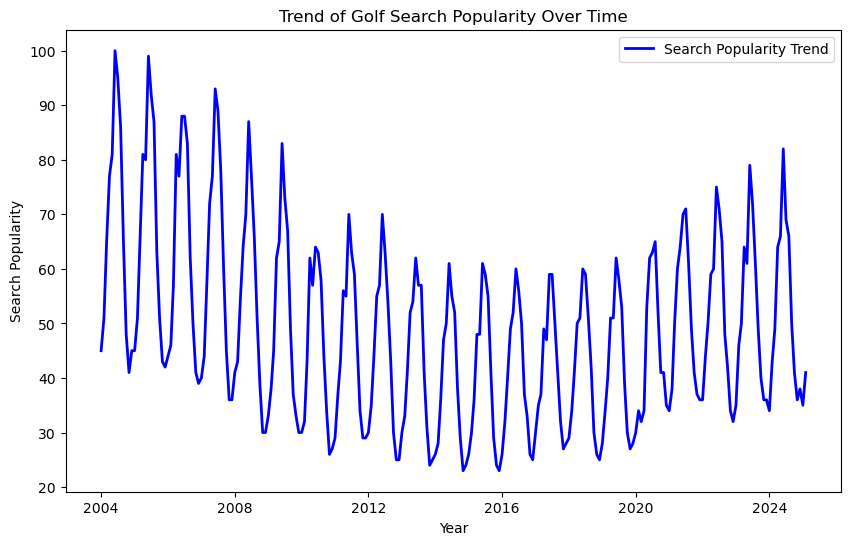

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(golf["Month"], golf["Search_Popularity"], color='blue', linewidth=2, label="Search Popularity Trend")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Search Popularity")
plt.title("Trend of Golf Search Popularity Over Time")
plt.legend()
plt.show()

In [78]:
y = golf["Search_Popularity"].values  # Response variable
n = len(y)  # Number of observations

# Construct the design matrix X_full
x = np.arange(1, n+1)  # Time index starting from 1
X_full = np.column_stack([np.ones(n), x - 1])  # First two columns: intercept and time index

# Add the hinge terms (t - k)+
for i in range(n-2):
    c = i + 2
    xc = ((x > c).astype(float)) * (x - c)  # Hinge function max(t - c, 0)
    X_full = np.column_stack([X_full, xc])
print(X_full)

[[  1.   0.  -0. ...  -0.  -0.  -0.]
 [  1.   1.   0. ...  -0.  -0.  -0.]
 [  1.   2.   1. ...  -0.  -0.  -0.]
 ...
 [  1. 251. 250. ...   1.   0.  -0.]
 [  1. 252. 251. ...   2.   1.   0.]
 [  1. 253. 252. ...   3.   2.   1.]]


In [79]:
# Fit the OLS model
mdfull = sm.OLS(y, X_full).fit()

# Display summary
mdfull.summary()

/srv/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/srv/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/srv/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 15 Mar 2025   Prob (F-statistic):                nan
Time:                        14:29:42   Log-Likelihood:                 5649.6
No. Observations:                 254   AIC:                        -1.079e+04
Df Residuals:                       0   BIC:                            -9893.
Df Model:                         253                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.0000        inf          0        nan         nan         nan
x1             6.0000        inf          0        nan         nan         nan
x2             8.0000        inf          0        nan         nan         nan
x3            -2.0000        inf         -0        nan         nan         nan
x4            -8.0000        inf         -0        nan         nan         nan
x5            15.0000        inf          0        nan         nan         nan
x6           -24.0000        inf         -0        nan         nan         nan
x7            -4.0000        inf         -0        nan         nan         nan
x8           -12.0000        inf         -0        nan         nan         nan
x9             4.0000        inf          0        nan         nan         nan
x10           10.0000        inf          0        nan         nan         nan
x11           11.0000        inf          0        nan         nan         nan
x12           -4.0000        inf         -0        nan         nan         nan
x13            6.0000        inf          0        nan         nan         nan
x14            8.0000        inf          0        nan         nan         nan
x15            2.0000        inf          0        nan         nan         nan
x16          -17.0000        inf         -0        nan         nan         nan
x17           20.0000        inf          0        nan         nan         nan
x18          -26.0000        inf         -0        nan         nan         nan
x19            2.0000        inf          0        nan         nan         nan
x20          -19.0000        inf         -0        nan         nan         nan
x21           12.0000        inf          0        nan         nan         nan
x22            4.0000        inf          0        nan         nan         nan
x23            7.0000        inf          0        nan         nan         nan
x24            3.0000        inf          0        nan         nan         nan
x25          3.14e-12        inf          0        nan         nan         nan
x26            9.0000        inf          0        nan         nan         nan
x27           13.0000        inf          0        nan         nan         nan
x28          -28.0000        inf         -0        nan         nan         nan
x29           15.0000        inf          0        nan         nan         nan
x30          -11.0000        inf         -0        nan         nan         nan
x31           -5.0000        inf         -0        nan         nan         nan
x32          -16.0000        inf         -0        nan         nan         nan
x33            9.0000        inf          0        nan         nan         nan
x34            3.0000        inf          0        nan         nan         nan
x35            7.0000        inf          0        nan         nan         nan
x3

In [80]:
print(y[0])
print(y[1] - y[0])
print(y[2] - y[1] - y[1] + y[0])

45
6
8


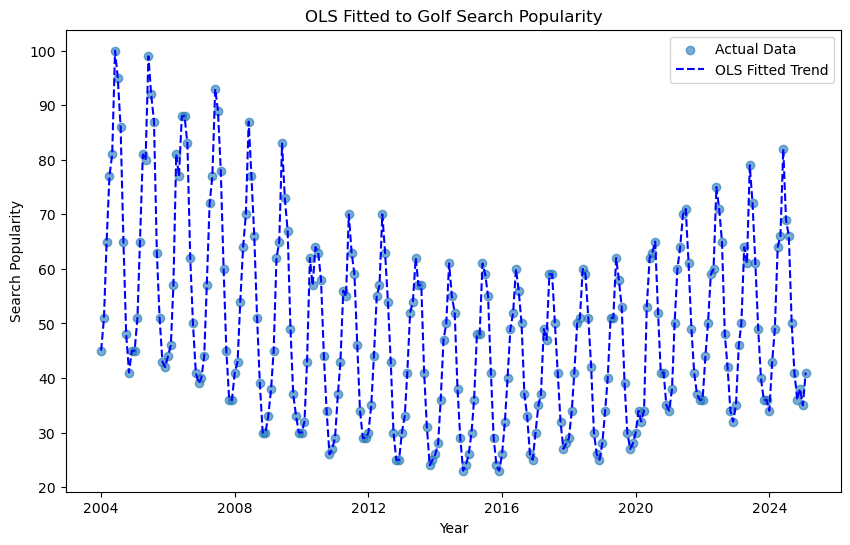

In [81]:
X_ols = X_full  # Use the same design matrix
ols_model = sm.OLS(y, X_ols).fit()
y_pred_ols = ols_model.predict(X_ols)

# Plot the data with OLS and Ridge regression fits
plt.figure(figsize=(10, 6))
plt.scatter(golf["Month"], y, label="Actual Data", alpha=0.6)
plt.plot(golf["Month"], y_pred_ols, color="blue", linestyle="--", label="OLS Fitted Trend")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Search Popularity")
plt.title("OLS Fitted to Golf Search Popularity")
plt.legend()
plt.show()

In [82]:
def solve_ridge(X, y, lambda_val, penalty_start=2):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.sum_squares(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value

In [83]:
b_ridge = solve_ridge(X_full, y, lambda_val = 100000)
print(b_ridge)

[ 6.98404771e+01 -2.32486588e-01 -2.48404771e-04 -6.82889446e-04
 -1.16112668e-03 -1.56078228e-03 -1.83951047e-03 -1.80494986e-03
 -1.50472063e-03 -1.02642496e-03 -5.77649949e-04 -3.25972448e-04
 -3.38963526e-04 -5.74190992e-04 -1.02921927e-03 -1.64160703e-03
 -2.26890266e-03 -2.74863814e-03 -3.08832274e-03 -3.09543825e-03
 -2.83743560e-03 -2.36173473e-03 -1.90572724e-03 -1.58678107e-03
 -1.48224515e-03 -1.59945252e-03 -1.91572138e-03 -2.40835397e-03
 -2.96463334e-03 -3.34181849e-03 -3.57713875e-03 -3.55779003e-03
 -3.28093248e-03 -2.79369068e-03 -2.30315638e-03 -1.92639340e-03
 -1.75044253e-03 -1.79232530e-03 -2.03904574e-03 -2.44758994e-03
 -2.88492361e-03 -3.19798799e-03 -3.33369546e-03 -3.12892641e-03
 -2.62052793e-03 -1.91531578e-03 -1.19007954e-03 -5.91589623e-04
 -2.06604556e-04 -3.18769366e-05 -1.41573021e-05 -1.30195870e-04
 -2.66742716e-04 -3.20546614e-04 -2.28353672e-04  1.83093211e-04
  8.17053415e-04  1.56678449e-03  2.28553583e-03  2.85654113e-03
  3.19301125e-03  3.29812

In [84]:
def ridge_cv(X, y, lambda_candidates):
    n = len(y)
    folds = []
    for i in range(5):
        test_indices = np.arange(i, n, 5)
        train_indices = np.array([j for j in range(n) if j % 5 != i])
        folds.append((train_indices, test_indices))
    cv_errors = {lamb: 0 for lamb in lambda_candidates}

    for train_index, test_index in folds:
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        for lamb in lambda_candidates:
            beta = solve_ridge(X_train, y_train, lambda_val = lamb)
            y_pred = np.dot(X_test, beta)
            squared_errors = (y_test - y_pred) ** 2
            cv_errors[lamb] += np.sum(squared_errors)
    for lamb in lambda_candidates:
        cv_errors[lamb] /= n
        
    best_lambda = min(cv_errors, key = cv_errors.get)

    return best_lambda, cv_errors

In [85]:
lambda_candidates = np.array([0.1, 1, 10, 100, 1000, 10000, 100000])
print(lambda_candidates)

best_lambda, cv_errors = ridge_cv(X_full, y, lambda_candidates)
print(best_lambda)
print("CV errors for each lambda:")
for lamb, error in sorted(cv_errors.items()):
    print(f"Lambda = {lamb:.2f}, CV Error = {error:.6f}")

[1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05]
1.0
CV errors for each lambda:
Lambda = 0.10, CV Error = 19.957231
Lambda = 1.00, CV Error = 19.465511
Lambda = 10.00, CV Error = 70.885799
Lambda = 100.00, CV Error = 187.693754
Lambda = 1000.00, CV Error = 221.272457
Lambda = 10000.00, CV Error = 225.876801
Lambda = 100000.00, CV Error = 227.934600


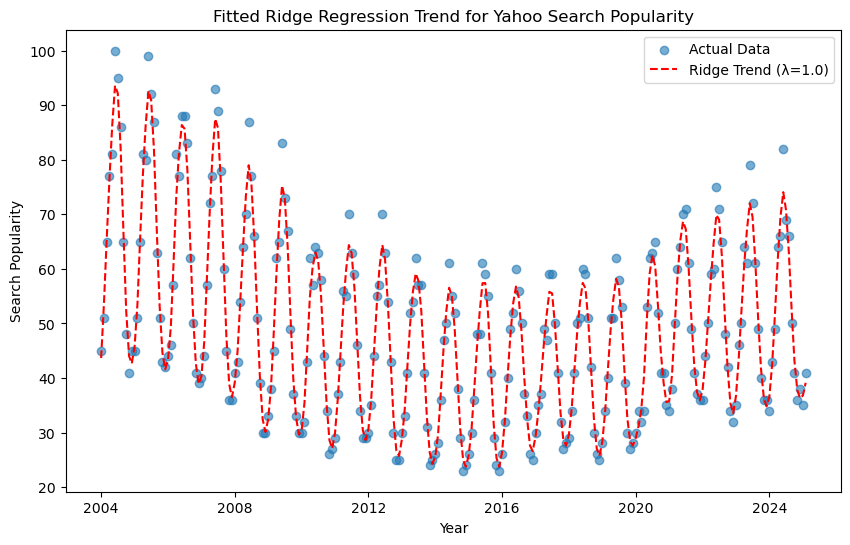

In [169]:
# Fit the ridge regression model using the best lambda
best_lambda = 1.0  # From cross-validation results
b_ridge = solve_ridge(X_full, y, best_lambda)

# Compute the fitted values
y_pred_ridge = X_full @ b_ridge

# Plot the actual data and the fitted ridge regression trend
plt.figure(figsize=(10, 6))
plt.scatter(golf["Month"], y, label="Actual Data", alpha=0.6)
plt.plot(golf["Month"], y_pred_ridge, color='red', label=f'Ridge Trend (λ={best_lambda})', linestyle="--")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Search Popularity")
plt.title("Fitted Ridge Regression Trend for Yahoo Search Popularity")
plt.legend()
plt.show()

#### Interpretation

The fitted ridge regression trend captures the overall structure of the data, including the cyclic seasonal patterns and long-term trend.

However, the ridge regression model appears to overfit the data, particularly in the periods where search popularity is high. The estimated trend closely follows the peaks of the data, suggesting that the model is not fully regularized and is still capturing some of the noise in the data.

Ideally, a good trend function should smooth out random fluctuations while still reflecting meaningful underlying patterns. In this case, while the ridge regression estimate does not fully interpolate the data, it still tracks short-term variations too closely, suggesting that $ \lambda $ could have been slightly larger to enforce more regularization.


## 5bi)

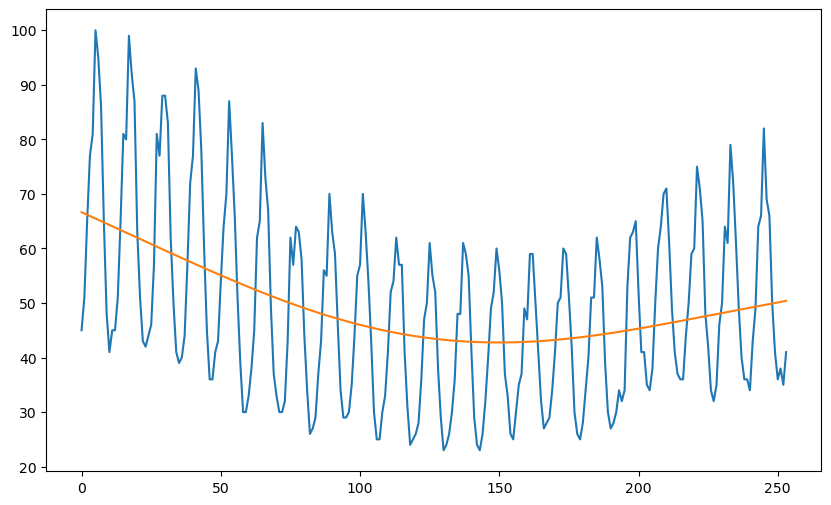

In [87]:
# Posterior mean of beta with fixed tau and sig
C = 10**4
#tau = 0.001
tau = .0001
sig = 0.2
Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, n-2)]))

XTX = np.dot(X_full.T, X_full)
TempMat = np.linalg.inv(np.linalg.inv(Q) + (XTX/(sig ** 2)))
XTy = np.dot(X_full.T, y)

betahat = np.dot(TempMat, XTy/(sig ** 2))
muhat = np.dot(X_full, betahat)

plt.figure(figsize = (10, 6))
plt.plot(y)
plt.plot(muhat)
plt.show()

In [88]:
#below penalty_start = 2 means that b0 and b1 are not included in the penalty
def solve_ridge(X, y, lambda_val, penalty_start=2):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.sum_squares(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value

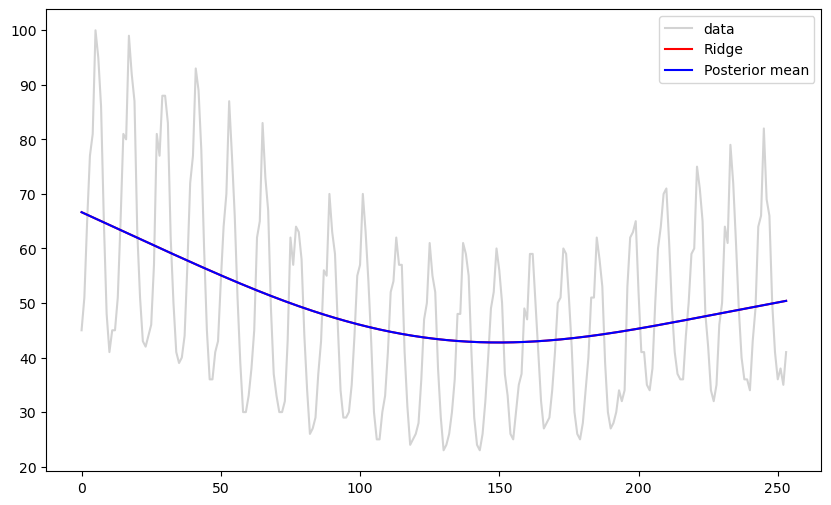

In [89]:
b_ridge = solve_ridge(X_full, y, lambda_val = (sig ** 2)/(tau ** 2))
ridge_fitted = np.dot(X_full, b_ridge)
plt.figure(figsize = (10, 6))
plt.plot(y, color = 'lightgray', label = 'data')
plt.plot(ridge_fitted, color = 'red', label = 'Ridge')
plt.plot(muhat, color = 'blue', label = 'Posterior mean')
plt.legend()
plt.show()

In [152]:
tau_gr = np.logspace(np.log10(0.01), np.log10(1), 100)
sig_gr = np.logspace(np.log10(0.1), np.log10(1), 100)
#sig_gr = np.array([0.16])

t, s = np.meshgrid(tau_gr, sig_gr)

g = pd.DataFrame({'tau': t.flatten(), 'sig': s.flatten()})

from joblib import Parallel, delayed

def compute_logpost(i):
    tau = g.loc[i, 'tau']
    sig = g.loc[i, 'sig']
    Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, n-2)]))
    Mat = np.linalg.pinv(Q + (X_full.T @ X_full) / (sig ** 2))
    Matinv = np.linalg.inv(Mat)
    sgn, logcovdet = np.linalg.slogdet(Matinv)
    sgnQ, logcovdetQ = np.linalg.slogdet(Q)
    logpost = (-n-1) * np.log(sig) - np.log(tau) - 0.5 * logcovdetQ + 0.5 * logcovdet - \
              ((np.sum(y ** 2)) / (2 * (sig ** 2))) + (y.T @ X_full @ Matinv @ X_full.T @ y) / (2 * (sig ** 4))
    return logpost

# Run in parallel
g['logpost'] = Parallel(n_jobs=-1)(delayed(compute_logpost)(i) for i in range(len(g)))

In [153]:
#Posterior maximizers:
max_row = g['logpost'].idxmax()
print(max_row)
tau_opt = g.loc[max_row, 'tau']
sig_opt = g.loc[max_row, 'sig']
print(tau_opt, sig_opt)

60
0.16297508346206444 0.1


In [154]:
# Normalize log posterior to get proper posterior weights
g['post'] = np.exp(g['logpost'] - np.max(g['logpost']))  # Avoid numerical underflow
g['post'] = g['post'] / np.sum(g['post'])  # Normalize

# Compute posterior mean estimates
tau_pm = np.sum(g['tau'] * g['post'])
sig_pm = np.sum(g['sig'] * g['post'])

# Compute Bayesian lambda estimate
bayesian_lambda_pm = (sig_pm ** 2) / (tau_pm ** 2)

# Print results
print("Posterior Mean Estimates:")
print("tau_pm:", tau_pm)
print("sig_pm:", sig_pm)
print("Bayesian lambda (posterior mean estimate):", bayesian_lambda_pm)

Posterior Mean Estimates:
tau_pm: 0.16297508346206444
sig_pm: 0.1
Bayesian lambda (posterior mean estimate): 0.3764935806792468


#### Interpretation

The tuning parameter $ \lambda $ obtained via cross-validation in Ridge regression was **1.0**. In the Bayesian framework, we estimated $ \tau $ and $ \sigma $ by computing their posterior distributions over a predefined range and selecting the maximum a posteriori (MAP) estimates. Using these values, we computed the Bayesian estimate of $ \lambda $ as:

$$
\hat{\lambda} = \frac{\hat{\sigma}^2}{\hat{\tau}^2}
$$

This yielded $ \hat{\lambda} = 0.376 $, which is slightly lower than the cross-validation estimate of 1.0.

This discrepancy can be attributed to the different regularization philosophies of Ridge regression and Bayesian inference:

- **Frequentist Ridge Regression (Cross-Validation):** Selects $ \lambda $ to minimize prediction error on held-out data.
- **Bayesian Approach:** Integrates prior information and uncertainty to estimate posterior distributions of model parameters.

Since $ \hat{\lambda}_{\text{Bayes}} $ is lower than $ \lambda_{\text{CV}} $, it suggests that the Bayesian model favors slightly less regularization than Ridge regression. This could be due to the choice of priors, as well as how cross-validation penalizes variance in model complexity.


## 5bii)

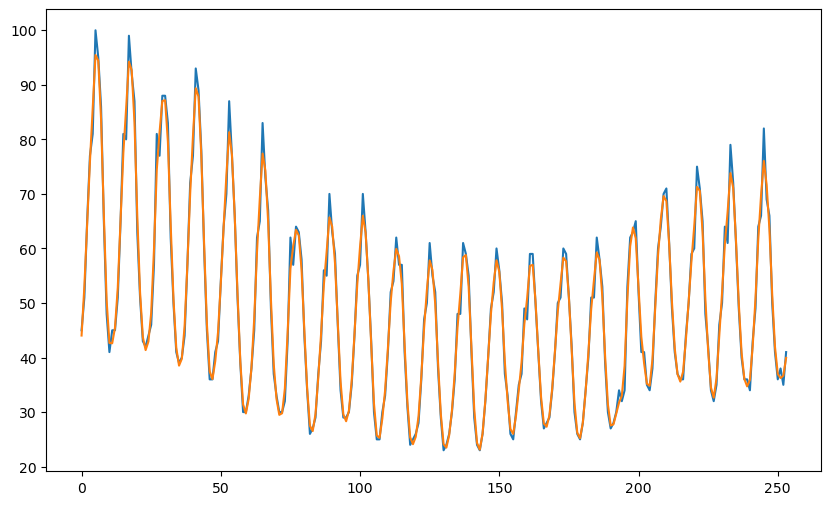

In [155]:
# Posterior mean of beta with tau_opt and sig_opt
C = 10**4
tau = tau_opt
sig = sig_opt
Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, n-2)]))

XTX = np.dot(X_full.T, X_full)
TempMat = np.linalg.inv(np.linalg.inv(Q) + (XTX/(sig ** 2)))
XTy = np.dot(X_full.T, y)

betahat = np.dot(TempMat, XTy/(sig ** 2))
muhat = np.dot(X_full, betahat)

plt.figure(figsize = (10, 6))
plt.plot(y)
plt.plot(muhat)
plt.show()

In [156]:
g['post'] = np.exp(g['logpost'] - np.max(g['logpost']))
g['post'] = g['post']/np.sum(g['post'])

In [157]:
print(g.head(10))

        tau  sig       logpost  post
0  0.010000  0.1  1.908268e+28   0.0
1  0.010476  0.1  1.908268e+28   0.0
2  0.010975  0.1  1.908268e+28   0.0
3  0.011498  0.1  1.908268e+28   0.0
4  0.012045  0.1  1.908268e+28   0.0
5  0.012619  0.1  1.908268e+28   0.0
6  0.013219  0.1  1.908268e+28   0.0
7  0.013849  0.1  1.908268e+28   0.0
8  0.014508  0.1  1.908268e+28   0.0
9  0.015199  0.1  1.908268e+28   0.0


In [158]:
tau_pm = np.sum(g['tau'] * g['post'])
sig_pm = np.sum(g['sig'] * g['post'])
print(tau_pm, sig_pm)

0.16297508346206444 0.1


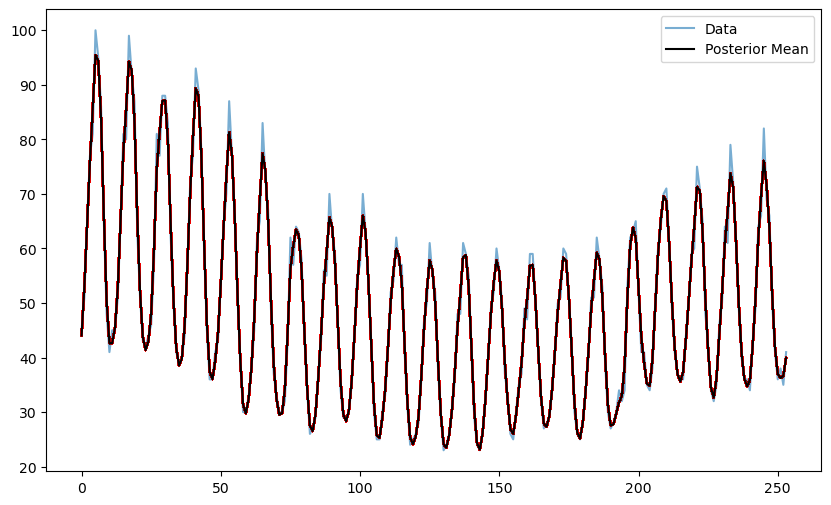

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

N = 1000  # Number of posterior samples

# Sample posterior values
samples = g.sample(N, weights=g['post'], replace=True)
tau_samples = np.array(samples.iloc[:, 0])
sig_samples = np.array(samples.iloc[:, 1])

# Precompute XTX outside the loop for efficiency
XTX = np.dot(X_full.T, X_full)

# Function to compute posterior samples
def compute_posterior(i):
    tau = tau_samples[i]
    sig = sig_samples[i]
    
    # Construct the Q matrix
    Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, n - 2)]))
    
    # Compute TempMat using pinv for stability
    TempMat = np.linalg.pinv(np.linalg.pinv(Q) + (XTX / (sig**2)))
    
    # Compute beta_hat and mu_hat
    XTy = np.dot(X_full.T, y)
    beta_hat = np.dot(TempMat, XTy / (sig**2))
    mu_hat = np.dot(X_full, beta_hat)
    
    return mu_hat

# Run computations in parallel
muhats = np.array(Parallel(n_jobs=-1)(delayed(compute_posterior)(i) for i in range(N)))

# Compute posterior mean
mu_est = np.mean(muhats, axis=0)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y, label="Data", alpha=0.6)

# Plot sampled functions
for i in range(N):
    plt.plot(muhats[i], color='red', alpha=0.1)  # Use low alpha to avoid overplotting

plt.plot(mu_est, color='black', label="Posterior Mean")
plt.legend()
plt.show()


#### Interpretation

In this step, we drew N = 1000 posterior samples from $\mu_t$ and plotted these sampled trend functions alongside the observed data. The black curve represents the posterior mean estimate, while the red curves represent posterior sampled trends with lower opacity to illustrate uncertainty.

The uncertainty in the posterior samples is reflected in the spread of the red lines. In regions where the data exhibits more fluctuation, we observe greater variability in the posterior samples, indicating higher uncertainty. Conversely, in stable regions, the posterior samples are more tightly concentrated around the posterior mean, suggesting greater confidence in the estimate.

The overall pattern captured by the posterior mean aligns well with the observed data, which suggests that our Bayesian regression approach effectively models the underlying trend while accounting for uncertainty. The variability observed in the posterior samples makes sense, given the periodic nature of the data and the level of noise in the observations.

## 5biii)

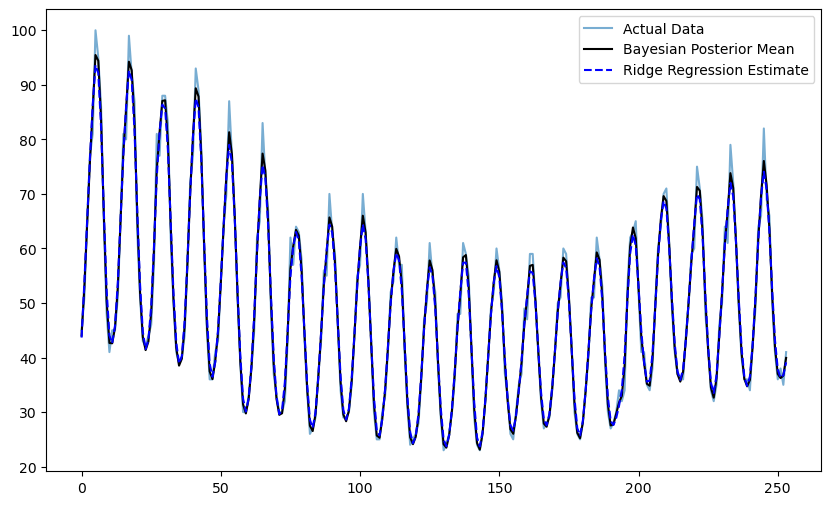

In [175]:
plt.figure(figsize=(10, 6))
plt.plot(y, label="Actual Data", alpha=0.6)
plt.plot(mu_est, label="Bayesian Posterior Mean", color="black")
plt.plot(y_pred_ridge, label="Ridge Regression Estimate", color="blue", linestyle="dashed")
plt.legend()
plt.show()

#### Interpretation

Both the Bayesian posterior mean estimate $\mu_t$ and the Ridge regression estimate produce similar overall trend estimates. However, the Bayesian model exhibits more sensitivity to fluctuations in the data, capturing finer variations that Ridge regression smooths out. This suggests that the Bayesian approach is incorporating more of the data's inherent variability, but it may also be overfitting compared to Ridge regression.

Ridge regression, on the other hand, prioritizes smoothness by shrinking coefficients uniformly, which results in a simpler, more stable trend that aligns with the overall structure of the data but does not respond as strongly to local fluctuations. This makes it a more robust option when the goal is to extract a general trend without being influenced by noise.

Between the two, the Ridge regression estimate is smoother and appears to generalize better, while the Bayesian model is more flexible but potentially overfits. Given this comparison, Ridge regression may be the preferred choice if the goal is to obtain a stable trend estimate that avoids overfitting.

## 6a)

In [204]:
# Load the dataset
golf = pd.read_csv("golf_data.csv")

# Drop the first row (which contains misplaced column headers)
golf = golf.iloc[1:].reset_index(drop=False)

# Rename columns for clarity
golf.columns = ["Month", "Search_Popularity"]

# Convert "Month" column to datetime format
golf["Month"] = pd.to_datetime(golf["Month"])
golf["Search_Popularity"] = pd.to_numeric(golf["Search_Popularity"])

y = golf["Search_Popularity"].values

# Check the data
golf

,Month,Search_Popularity
0,2004-01-01,45
1,2004-02-01,51
2,2004-03-01,65
3,2004-04-01,77
4,2004-05-01,81
...,...,...
249,2024-10-01,41
250,2024-11-01,36
251,2024-12-01,38
252,2025-01-01,35


Optimal lambda from cross-validation: 0.16768329368110074


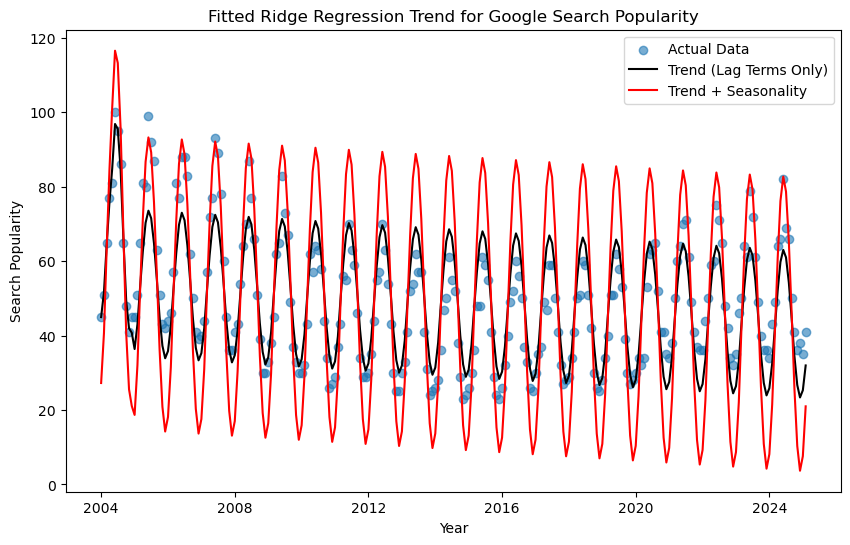

In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

# Load dataset (assuming golf dataset is already loaded)
y = golf["Search_Popularity"].values
t = np.arange(len(y))  # Time index

# Number of lag terms
n_lags = 12  # Adjust as needed

# Construct design matrix X with lagged terms and seasonal terms
X = np.column_stack([((t - i).clip(min=0)) for i in range(1, n_lags + 1)])  # Lag terms
X = np.column_stack([X, np.cos(2 * np.pi * t / 12), np.sin(2 * np.pi * t / 12)])  # Seasonal terms

# Define Ridge Regression with Cross-Validation
def ridge_cv(X, y, lambda_candidates):
    """Perform cross-validation to select the best lambda for Ridge Regression."""
    n = len(y)
    folds = []
    
    # Create 5-fold split
    for i in range(5):
        test_indices = np.arange(i, n, 5)
        train_indices = np.array([j for j in range(n) if j % 5 != i])
        folds.append((train_indices, test_indices))
    
    # Store cross-validation errors
    cv_errors = {lamb: 0 for lamb in lambda_candidates}
    
    # Perform cross-validation
    for train_index, test_index in folds:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        for lamb in lambda_candidates:
            ridge = Ridge(alpha=lamb)
            ridge.fit(X_train, y_train)
            y_pred = ridge.predict(X_test)
            cv_errors[lamb] += np.sum((y_test - y_pred) ** 2)
    
    # Compute average error
    for lamb in lambda_candidates:
        cv_errors[lamb] /= len(folds)
    
    # Select the best lambda (minimum CV error)
    best_lambda = min(cv_errors, key=cv_errors.get)
    
    return best_lambda, cv_errors

# Define lambda candidates for search
lambda_candidates = np.logspace(-2, 2, 50)  # Log scale from 0.01 to 100

# Find best lambda using cross-validation
best_lambda, cv_errors = ridge_cv(X, y, lambda_candidates)
print(f"Optimal lambda from cross-validation: {best_lambda}")

# Fit Ridge Regression using optimal lambda
ridge = Ridge(alpha=best_lambda)
ridge.fit(X, y)

# Compute trend estimates
y_trend = ridge.predict(X)  # Trend estimate
y_seasonal = y_trend + ridge.coef_[-2] * np.cos(2 * np.pi * t / 12) + ridge.coef_[-1] * np.sin(2 * np.pi * t / 12)

# Plot Results
plt.figure(figsize=(10, 6))
plt.scatter(golf["Month"], y, label="Actual Data", alpha=0.6)
plt.plot(golf["Month"], y_trend, color="black", label="Trend (Lag Terms Only)")
plt.plot(golf["Month"], y_seasonal, color="red", label="Trend + Seasonality")

plt.xlabel("Year")
plt.ylabel("Search Popularity")
plt.title("Fitted Ridge Regression Trend for Google Search Popularity")
plt.legend()
plt.show()


#### Comments

The trend+ seasonality model (red line) closely follows the fluctuations in the data, capturing the periodic structure well. However, it appears to overfit- the oscillations often exceed the actual data points, suggesting it is too sensitive to short-term variations. This overfitting is evident in the exagerrated peaks and troughs that go beyond the actual observations. The Lag term only model is much smoother, avoiding extreme fluctuations. It does not overfit but provides a general trend estimation, capturing the long term direction of the data. This model seems more robust for understanding the underlying data structure without fully interpolating it. 

## 6bi)

In [206]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# Define tau and sigma grids
tau_gr = np.logspace(np.log10(0.01), np.log10(1), 100)
sig_gr = np.logspace(np.log10(0.1), np.log10(10), 100)

# Create meshgrid for tau and sigma values
t, s = np.meshgrid(tau_gr, sig_gr)
g = pd.DataFrame({'tau': t.flatten(), 'sig': s.flatten()})

# Define the function to compute the log posterior
def compute_logpost(i):
    tau = np.array([g.loc[i, 'tau']])  # Ensure tau is an array
    sig = np.array([g.loc[i, 'sig']])  # Ensure sig is an array

    # Construct the Q matrix
    Q = np.diag(np.concatenate(([C, C], np.repeat(tau**2, X_full.shape[0] - 2))))

    # Compute Mat and Matinv
    Mat = np.linalg.pinv(Q + (X_full.T @ X_full) / (sig**2))
    Matinv = np.linalg.inv(Mat)

    # Compute log determinant terms
    signQ, logdetQ = np.linalg.slogdet(Q)
    signM, logdetM = np.linalg.slogdet(Matinv)

    # Compute the log posterior
    logpost = (-X_full.shape[0]) * np.log(sig) - np.log(tau) - 0.5 * logdetQ + 0.5 * logdetM - \
              ((np.sum(y**2)) / (2 * (sig**2))) + (y.T @ X_full @ Matinv @ X_full.T @ y) / (2 * (sig**4))

    return logpost

# Run parallel computations
g['logpost'] = Parallel(n_jobs=-1)(delayed(compute_logpost)(i) for i in range(len(g)))

# Find posterior maximizers
max_row = g['logpost'].idxmax()
tau_opt = g.loc[max_row, 'tau']
sig_opt = g.loc[max_row, 'sig']

print("Optimal tau:", tau_opt)
print("Optimal sigma:", sig_opt)

# Normalize log posterior for proper posterior weights
logpost_values = np.array(g['logpost'].to_numpy().flatten(), dtype=np.float64)
g['post'] = np.exp(logpost_values - np.max(logpost_values))   # Apply exponentiation
g['post'] /= np.sum(g['post'])  # Normalize

# Compute posterior mean estimates
tau_pm = np.sum(g['tau'] * g['post'])
sig_pm = np.sum(g['sig'] * g['post'])

# Compute Bayesian lambda estimate
bayesian_lambda_pm = (sig_pm**2) / (tau_pm**2)

# Print results
print("Posterior Mean Estimates:")
print("tau_pm:", tau_pm)
print("sig_pm:", sig_pm)
print("Bayesian lambda (posterior mean estimate):", bayesian_lambda_pm)

Optimal tau: 0.13530477745798075
Optimal sigma: 0.1
Posterior Mean Estimates:
tau_pm: 0.13530477745798075
sig_pm: 0.1
Bayesian lambda (posterior mean estimate): 0.5462277217684338


/tmp/ipykernel_70/1740032095.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logpost_values = np.array(g['logpost'].to_numpy().flatten(), dtype=np.float64)


## 6bii)

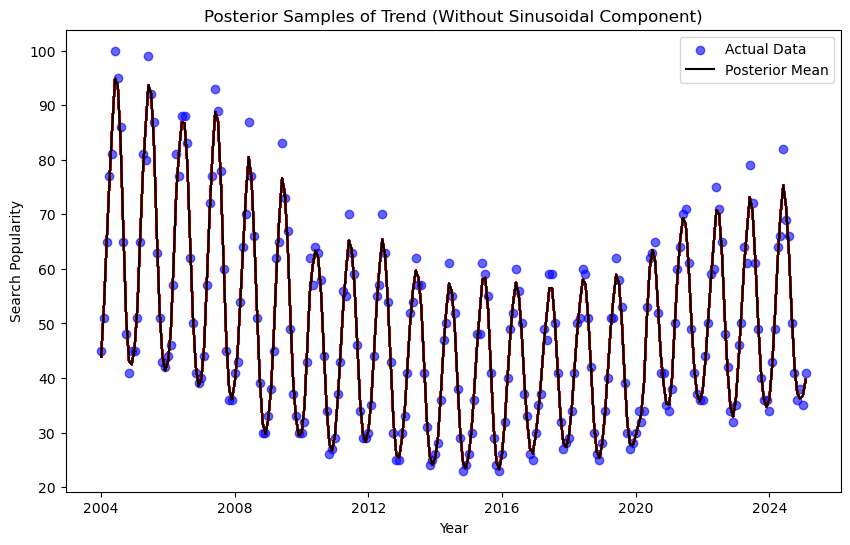

In [207]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

N = 1000  # Number of posterior samples

# Sample posterior values
samples = g.sample(N, weights=g["post"], replace=True)
tau_samples = np.array(samples.iloc[:, 0])
sig_samples = np.array(samples.iloc[:, 1])

# Precompute XTX outside the loop for efficiency
XTX = np.dot(X_full.T, X_full)

# Function to compute posterior samples
def compute_posterior(i):
    tau = tau_samples[i]
    sig = sig_samples[i]
    
    # Construct the Q matrix
    Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, X_full.shape[1] - 2)]))

    # Compute TempMat using pinv for stability
    TempMat = np.linalg.pinv(np.linalg.pinv(Q) + (XTX / (sig**2)))

    # Compute beta_hat and mu_hat
    XTy = np.dot(X_full.T, y)
    beta_hat = np.dot(TempMat, XTy / (sig**2))
    mu_hat = np.dot(X_full, beta_hat)

    return mu_hat

# Run computations in parallel
muhats = np.array(Parallel(n_jobs=-1)(delayed(compute_posterior)(i) for i in range(N)))

# Compute posterior mean
mu_est = np.mean(muhats, axis=0)

# Plot the scatter plot of data
plt.figure(figsize=(10, 6))
plt.scatter(golf["Month"], y, label="Actual Data", alpha=0.6, color="blue")

# Plot sampled functions with low alpha to avoid overplotting
for i in range(N):
    plt.plot(golf["Month"], muhats[i], color='red', alpha=0.05)

# Plot posterior mean in black
plt.plot(golf["Month"], mu_est, color='black', label="Posterior Mean")

# Labels and legend
plt.xlabel("Year")
plt.ylabel("Search Popularity")
plt.title("Posterior Samples of Trend (Without Sinusoidal Component)")
plt.legend()
plt.show()


#### Comments

Based on the results, the posterior samples of $\mu_t$ (without the sinusoidal component) are overlaid on the scatter plot of the actual data. The trend functions appear to capture the underlying patterns in the data well. However, given the density of the posterior samples, we can analyze the uncertainty revealed in the plot. The uncertainty in the trend estimation is relatively small, as the sampled functions are closely concentrated around the posterior mean. The model captures the overall trend while avoiding excessive interpolation, meaning it provides a smoothed representation of the data rather than perfectly fitting each point. The spread of the posterior samples suggests that the Bayesian model effectively accounts for variability in the data without overfitting. The uncertainty appears reasonable, as the variance in trend estimates follows the fluctuations in the observed data. This suggests the model correctly recognizes periods of more stable popularity trends versus more volatile fluctuations.

## 6biii)

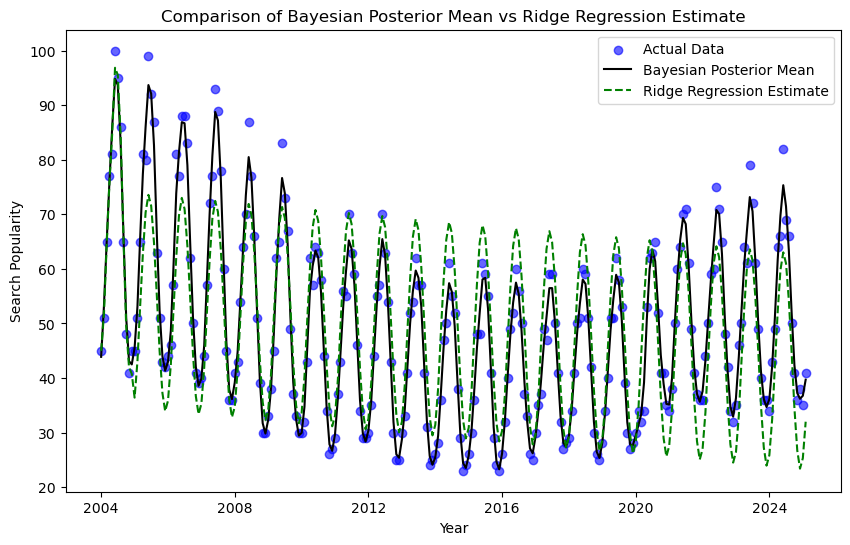

In [208]:
# Compute Bayesian posterior mean estimate
mu_bayes_est = np.mean(muhats, axis=0)

# Plot the actual data
plt.figure(figsize=(10, 6))
plt.scatter(golf["Month"], y, label="Actual Data", alpha=0.6, color="blue")

# Plot the Bayesian posterior mean estimate
plt.plot(golf["Month"], mu_bayes_est, color='black', label="Bayesian Posterior Mean")

# Plot Ridge Regression estimate from part (a)
plt.plot(golf["Month"], y_trend, color='green', linestyle="--", label="Ridge Regression Estimate")

# Labels and legend
plt.xlabel("Year")
plt.ylabel("Search Popularity")
plt.title("Comparison of Bayesian Posterior Mean vs Ridge Regression Estimate")
plt.legend()
plt.show()


#### Comments

While Ridge Regression is generally known for producing a smoother estimate, in this case, it overfits in regions where the data has higher values. This suggests that the regularization effect may not be strong enough to balance trend estimation and variability.
The Bayesian Posterior Mean, on the other hand, provides a well-regularized estimate that avoids overfitting while still capturing meaningful patterns in the data.The Ridge Regression estimate (green dashed line) fluctuates significantly in areas where the data exhibits high values, making it less robust in capturing long-term trends. The Bayesian Posterior Mean (black line) provides a more stable and interpretable trend, balancing short-term fluctuations and long-term structure effectively. Since Bayesian inference incorporates prior knowledge and uncertainty, it offers a more principled way to estimate trends while accounting for variability.